In [1]:
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os,sys
import numpy as np
import pandas as pd

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), '../..', 'src')
sys.path.append(src_dir)

%aimport plot_utils
from plot_utils import *
%aimport preprocessing
from preprocessing import *
%aimport data_source
from data_source import *
%aimport model_manage
from model_manage import *
%aimport model_regression
from model_regression import *

import logging
from utils import *
set_logger(logging.DEBUG)

In [2]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

In [3]:
ds = DataSource(host='localhost',port=5432, username='postgres', password='', database='sdra')
ds.show_views()
#ds.update_views()

[dp] connect to database postgresql://postgres:@localhost:5432/sdra
[dp] supported views: ['properties', 'property_features', 'transactions', 'property_addresses', 'property_address_transactions', 'property_transaction_valid', 'property_address_school_transactions']


In [4]:
df_transaction = ds.get_view_df('property_address_transactions')
df_property = ds.get_view_df('property_addresses')
print(df_transaction.shape)
print(df_property.shape)

(1475109, 25)
(709325, 22)


In [5]:
pp = Preprocess(df_transaction, df_property, target='sold_price')

In [6]:
use_features = pp.get_feature_list()
school_features = ['min_elem_distance', 'min_middle_distance', 'min_high_distance',
                   'elem_rating', 'middle_rating', 'high_rating',
                   'avg_elem_rating', 'avg_high_rating', 'avg_middle_rating']
use_features_base = ['date', 'pool', 'num_bed', 'view', 'num_bath', 'impr_over_land', 'sqft',
                     'sold_price_zip_avg', 'sqft_price_zip_avg', 'sqft_over_zip_avg', 'sqft_zip_avg', 'eval_zip_avg', 'eval_over_zip_avg', 
                     'lon', 'lat', ]
use_features_base

['date',
 'pool',
 'num_bed',
 'view',
 'num_bath',
 'impr_over_land',
 'sqft',
 'sold_price_zip_avg',
 'sqft_price_zip_avg',
 'sqft_over_zip_avg',
 'sqft_zip_avg',
 'eval_zip_avg',
 'eval_over_zip_avg',
 'lon',
 'lat']

In [8]:
# records of last 4 years
#use_features = ['sqft', 'num_bed', 'num_bath', 'view', 'pool', 'sqft_zip_avg', 'sqft_price_zip_avg', 'sold_price_zip_avg', 'impr_over_land']
df_track = pp.dataset(feature='delivered', valid=True, date=('2013-10-01', '2017-10-01'))
print(df_track.shape)
df_track.head()

[dp] transforming date
[dp] transforming view
[dp] transforming pool
[dp] transforming impr_over_land
[dp] transforming sold_year
[dp] transforming sold_month
[dp] transforming sold_age
[dp] transforming eval
[dp] transforming eval_sqft_price
[dp] making sqft_zip_avg
[dp] making sqft_over_zip_avg
[dp] making sqft_price_zip_avg
[dp] making sold_price_zip_avg
[dp] making eval_zip_avg
[dp] making eval_over_zip_avg
[dp] making sale_count_zip
[dp] cleaning on criteria: sold_price
[dp] cleaning on criteria: sqft_price
[dp] cleaning on criteria: sqft
[dp] cleaning on criteria: num_bed
[dp] cleaning on criteria: num_bath
[dp] cleaning on criteria: lon


(132409, 17)


,sqft_price_zip_avg,sold_price,pool,impr_over_land,view,id,sqft,lat,num_bed,eval_over_zip_avg,num_bath,lon,eval_zip_avg,sqft_over_zip_avg,sold_price_zip_avg,sqft_zip_avg,date
0,509.574024,430000,0,2.071439,0,1317161,1116,32.70949,2.0,0.770870,2.0,-117.15430,611104.270065,1.028692,565455.531453,1084.872831,2013-10-01
123505,226.977778,212000,0,1.585380,0,1317274,916,32.73340,2.0,0.624384,2.0,-116.96029,414168.244444,0.543757,360923.333333,1684.575556,2013-10-01
79898,248.747210,557000,0,1.226441,0,1317211,2608,33.15760,3.0,1.189223,2.0,-117.19599,494368.200873,1.374783,450904.657933,1897.026201,2013-10-01
79899,248.747210,339000,0,1.600006,0,1317288,1354,33.14983,4.0,0.724288,2.0,-117.15191,494368.200873,0.713749,450904.657933,1897.026201,2013-10-01
39727,312.467037,595000,0,1.085008,0,1317242,2127,32.94014,4.0,0.838233,3.0,-117.06459,749747.010723,0.932618,680984.114376,2280.677522,2013-10-01


### validate sliding_window with dataset of last 4 months

In [26]:
### baseline
rf = RandomForestRegressor(n_estimators=100, max_depth=14, n_jobs=-1, random_state=17)
mm = ModelManager(df_track, use_features_base, rf, target='sold_price', time_series=True)
monthly_volume = int(df_track.shape[0] / 24)
mm.run(sliding_window=monthly_volume*12, test_size=monthly_volume*4)

[dp] track/sliding/test window size: 110341, 66204, 22068
[dp] validation step is skipped
[dp] training size: 66204


110365.24179770438

In [27]:
### regress whole data with fixed sliding_window: 12
### no validation
rf = RandomForestRegressor(n_estimators=100, max_depth=14, n_jobs=-1, random_state=17)
mr = ModelRegression(use_features_base, rf)
errors = mr.regress(df_track, time_series=True, sliding_window=12)

[dp] prediction - data shape: (20579, 17), period: 2013-10-01 ~ 2014-05-30, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 9888, 9888, 10691
[dp] validation step is skipped
[dp] training size: 9888
[dp] prediction - data shape: (31812, 17), period: 2013-10-01 ~ 2014-09-30, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 20579, 20579, 11233
[dp] validation step is skipped
[dp] training size: 20579
[dp] prediction - data shape: (38559, 17), period: 2013-10-01 ~ 2015-01-30, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 31812, 31812, 6747
[dp] validation step is skipped
[dp] training size: 31812
[dp] prediction - data shape: (40070, 17), period: 2014-02-03 ~ 2015-05-29, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 28303, 28303, 11767
[dp] validation step is skipped
[dp] training size: 28303
[dp] prediction - data shape: (42924, 17), period: 2014-06-02 ~ 2015-09-30, sliding(in month): 12, test: 4
[dp] track/

### regress with validation for optimized sliding window

In [14]:
rf = RandomForestRegressor(n_estimators=20, max_depth=9, n_jobs=-1, random_state=17)
ntrees = np.arange(20,30,40)
depths = np.arange(12,13)
parameters = { 'n_estimators': ntrees, 'max_depth': depths}

mr = ModelRegression(use_features_base, rf)
errors = mr.regress(df_track, param_grid=parameters, GridSearchCV={'verbose':True, 'n_jobs':-1})

[dp] prediction - data shape: (20579, 17), period: 2013-10-01 ~ 2014-05-30, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 9888, 0, 10691
[dp] training size: 9888
[dp] prediction - data shape: (31812, 17), period: 2013-10-01 ~ 2014-09-30, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 20579, 9888, 11233
[dp] training size: 20579
[dp] prediction - data shape: (38559, 17), period: 2013-10-01 ~ 2015-01-30, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 31812, 20579, 6747
[dp] training size: 31812
[dp] prediction - data shape: (40070, 17), period: 2014-02-03 ~ 2015-05-29, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 28303, 21525, 11767
[dp] training size: 28303
[dp] prediction - data shape: (42924, 17), period: 2014-06-02 ~ 2015-09-30, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 29576, 17809, 13348
[dp] training size: 29576
[dp] validation - data shape: (73256, 17), sliding(in month)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.8s finished
[dp] validation - sliding(in month):4, score: -8724544572.959164
[dp] validation - data shape: (73256, 17), sliding(in month): 8, period: 2013-10-01 ~ 2016-01-29
[dp] track/sliding/test window size: 63282, 18545, 9974
[dp] walk-forward train:(18545,), test:(9974,), scope:0 ~ 28518
[dp] walk-forward train:(18545,), test:(9974,), scope:9974 ~ 38492
[dp] walk-forward train:(18545,), test:(9974,), scope:19948 ~ 48466
[dp] walk-forward train:(18545,), test:(9974,), scope:29922 ~ 58440
[dp] training size: 63282


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    4.2s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    5.4s finished
[dp] validation - sliding(in month):8, score: -8205625810.311242
[dp] validation - data shape: (73256, 17), sliding(in month): 12, period: 2013-10-01 ~ 2016-01-29
[dp] track/sliding/test window size: 63282, 29892, 9974
[dp] walk-forward train:(29892,), test:(9974,), scope:0 ~ 39865
[dp] walk-forward train:(29892,), test:(9974,), scope:9974 ~ 49839
[dp] walk-forward train:(29892,), test:(9974,), scope:19948 ~ 59813
[dp] training size: 63282


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.8s finished
[dp] validation - sliding(in month):12, score: -7796880370.948868
[dp] prediction - data shape: (41444, 17), period: 2014-10-01 ~ 2016-01-29, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 31470, 18343, 9974
[dp] training size: 31470
[dp] prediction - data shape: (46431, 17), period: 2015-02-02 ~ 2016-05-31, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 34697, 24723, 11734
[dp] training size: 34697
[dp] prediction - data shape: (48063, 17), period: 2015-06-01 ~ 2016-09-30, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 34582, 22790, 13481
[dp] training size: 34582
[dp] prediction - data shape: (45134, 17), period: 2015-10-01 ~ 2017-01-31, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 34715, 21234, 10419
[dp] training size: 34715
[dp] prediction - data shape: (46866, 17), period: 2016-02-01 ~ 2017-05-31, sliding(in month): 12, test:

In [15]:
errors

[100256.95178002786,
 92716.80300517974,
 89688.99359478887,
 91942.74621470789,
 88014.2004806545,
 80914.81954441719,
 73139.3866088831,
 66882.54138528834,
 63754.84431664817,
 75917.21074045192,
 117830.85780206378]

In [25]:
rf = RandomForestRegressor(n_estimators=20, max_depth=9, n_jobs=-1, random_state=17)
ntrees = np.arange(20,30,40)
depths = np.arange(12,13)
parameters = { 'n_estimators': ntrees, 'max_depth': depths}

mr = ModelRegression(use_features_base, rf)
errors = mr.regress(df_track, param_grid=parameters)

[dp] prediction - data shape: (20579, 17), period: 2013-10-01 ~ 2014-05-30, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 9888, 0, 10691
[dp] training size: 9888
[dp] prediction - data shape: (31812, 17), period: 2013-10-01 ~ 2014-09-30, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 20579, 9888, 11233
[dp] training size: 20579
[dp] prediction - data shape: (38559, 17), period: 2013-10-01 ~ 2015-01-30, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 31812, 20579, 6747
[dp] training size: 31812
[dp] prediction - data shape: (40070, 17), period: 2014-02-03 ~ 2015-05-29, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 28303, 21525, 11767
[dp] training size: 28303
[dp] prediction - data shape: (42924, 17), period: 2014-06-02 ~ 2015-09-30, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 29576, 17809, 13348
[dp] training size: 29576
[dp] validation - data shape: (73256, 17), sliding(in month)

In [24]:
errors

[100256.95178002786,
 92716.80300517974,
 89688.99359478887,
 91942.74621470789,
 88014.2004806545,
 77690.1393691508,
 72639.06457120177,
 65745.49336866837,
 62592.18900352895,
 74964.97859907943,
 116874.90911042152]

### regression on dateset of all time long

In [26]:
df_all = pp.dataset(feature='delivered', valid=True, date=('1985-10-01', '2017-10-01'))
mr_full = ModelRegression(use_features_base, rf)

[dp] transforming date
[dp] transforming view
[dp] transforming pool
[dp] transforming impr_over_land
[dp] transforming sold_year
[dp] transforming sold_month
[dp] transforming sold_age
[dp] transforming eval
[dp] transforming eval_sqft_price
[dp] making sqft_zip_avg
[dp] making sqft_over_zip_avg
[dp] making sqft_price_zip_avg
[dp] making sold_price_zip_avg
[dp] making eval_zip_avg
[dp] making eval_over_zip_avg
[dp] making sale_count_zip
[dp] cleaning on criteria: sold_price
[dp] cleaning on criteria: sqft_price
[dp] cleaning on criteria: sqft
[dp] cleaning on criteria: num_bed
[dp] cleaning on criteria: num_bath
[dp] cleaning on criteria: lon


In [11]:
### regress with 12-month sliding window
mr_full.regress(df_all, sliding_window=12)

[dp] prediction - data shape: (26051, 17), period: 1985-10-01 ~ 1986-05-30, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 13403, 13403, 12648
[dp] validation step is skipped
[dp] training size: 13403
[dp] prediction - data shape: (43749, 17), period: 1985-10-01 ~ 1986-09-30, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 26051, 26051, 17698
[dp] validation step is skipped
[dp] training size: 26051
[dp] prediction - data shape: (61867, 17), period: 1985-10-01 ~ 1987-01-30, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 43749, 43749, 18118
[dp] validation step is skipped
[dp] training size: 43749
[dp] prediction - data shape: (63207, 17), period: 1986-02-03 ~ 1987-05-29, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 47724, 47724, 15483
[dp] validation step is skipped
[dp] training size: 47724
[dp] prediction - data shape: (69151, 17), period: 1986-06-02 ~ 1987-09-30, sliding(in month): 12, test: 4
[dp] tr

[dp] prediction - data shape: (59610, 17), period: 1997-06-02 ~ 1998-09-30, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 41727, 41727, 17883
[dp] validation step is skipped
[dp] training size: 41727
[dp] prediction - data shape: (59477, 17), period: 1997-10-01 ~ 1999-01-29, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 45093, 45093, 14384
[dp] validation step is skipped
[dp] training size: 45093
[dp] prediction - data shape: (63615, 17), period: 1998-02-02 ~ 1999-05-30, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 46750, 46750, 16865
[dp] validation step is skipped
[dp] training size: 46750
[dp] prediction - data shape: (67521, 17), period: 1998-06-01 ~ 1999-09-30, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 48691, 48691, 18830
[dp] validation step is skipped
[dp] training size: 48691
[dp] prediction - data shape: (64161, 17), period: 1998-10-01 ~ 2000-01-31, sliding(in month): 12, test: 4
[dp] 

[dp] prediction - data shape: (43678, 17), period: 2009-10-01 ~ 2011-01-31, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 34187, 34187, 9491
[dp] validation step is skipped
[dp] training size: 34187
[dp] prediction - data shape: (42597, 17), period: 2010-02-01 ~ 2011-05-31, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 32310, 32310, 10287
[dp] validation step is skipped
[dp] training size: 32310
[dp] prediction - data shape: (42345, 17), period: 2010-06-01 ~ 2011-09-30, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 31021, 31021, 11324
[dp] validation step is skipped
[dp] training size: 31021
[dp] prediction - data shape: (40660, 17), period: 2010-10-01 ~ 2012-01-31, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 30923, 30923, 9737
[dp] validation step is skipped
[dp] training size: 30923
[dp] prediction - data shape: (42554, 17), period: 2011-02-01 ~ 2012-05-31, sliding(in month): 12, test: 4
[dp] tr

[43976.5131943247,
 47258.108516511435,
 51938.43130005981,
 52697.61388399104,
 52469.42535143521,
 57828.14507432424,
 65992.41967871466,
 61310.74741638329,
 67526.06607573776,
 80438.44977031487,
 86437.79605818572,
 76353.24182930295,
 73275.66718346505,
 67321.28275376746,
 68197.78611503095,
 83027.85349115841,
 69021.8530740052,
 75067.97554234123,
 69291.41096975534,
 73070.83394323215,
 70981.67684203073,
 64229.412122328155,
 70353.3771261755,
 74487.02677503468,
 67845.87885902674,
 75533.88347148789,
 77519.7135729078,
 66025.6173919984,
 74367.10625383297,
 75471.51438888807,
 73542.13355548852,
 76345.40536627048,
 83708.63052235862,
 82330.75581368966,
 83374.72473666971,
 82801.52959543689,
 90032.72021637701,
 92556.27170145066,
 85775.48145560206,
 86737.68257640368,
 89007.37284915875,
 97354.82533282891,
 109216.55934316186,
 103161.93046414743,
 109664.62544280181,
 96044.99254010318,
 92961.21241685605,
 97132.75128609609,
 100374.8257721562,
 101894.35908631419,

[dp] data range: 1985-10-01 - 2017-09-27
[dp] sliding_windows: [4, 8, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]
[dp] errors: [43976.5131943247, 47258.108516511435, 51938.43130005981, 52697.61388399104, 52469.42535143521, 57828.14507432424, 65992.41967871466, 61310.74741638329, 67526.06607573776, 80438.44977031487, 86437.79605818572, 76353.24182930295, 73275.66718346505, 67321.28275376746, 68197.78611503095, 83027.85349115841, 69021.8530740052, 75067.97554234123, 69291.41096975534, 73070.83394323215, 70981.67684203073, 64229.412122328155, 70353.3771261755, 74487.02677503468, 67845.87885902674, 75533.88347148789, 77519.7135729078, 66025.6173919984, 74367.106253832

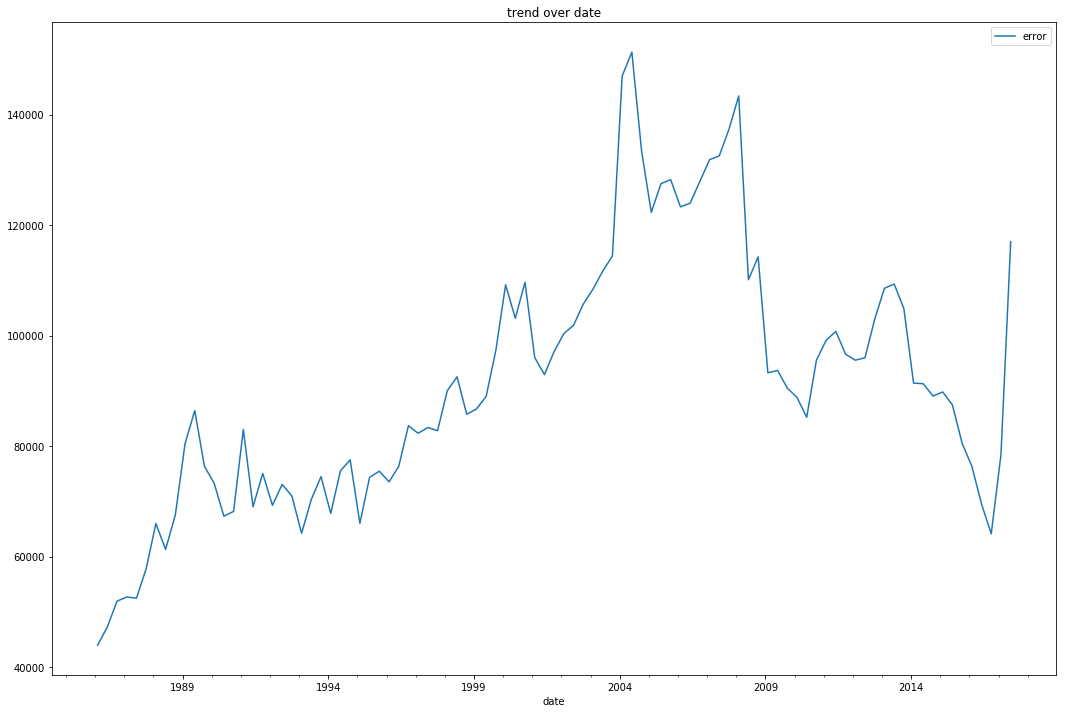

In [13]:
df_sum_12 = mr_full.summary()
plot_trends(df_sum_12, ['error'])

In [14]:
### regress with 4-month sliding window
mr_full.regress(df_all, sliding_window=4)

[dp] prediction - data shape: (26051, 17), period: 1985-10-01 ~ 1986-05-30, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 13403, 13403, 12648
[dp] validation step is skipped
[dp] training size: 13403
[dp] prediction - data shape: (29961, 17), period: 1986-02-03 ~ 1986-09-30, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 12263, 12263, 17698
[dp] validation step is skipped
[dp] training size: 12263
[dp] prediction - data shape: (35816, 17), period: 1986-06-02 ~ 1987-01-30, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 17698, 17698, 18118
[dp] validation step is skipped
[dp] training size: 17698
[dp] prediction - data shape: (33246, 17), period: 1986-10-01 ~ 1987-05-29, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 17763, 17763, 15483
[dp] validation step is skipped
[dp] training size: 17763
[dp] prediction - data shape: (33335, 17), period: 1987-02-02 ~ 1987-09-30, sliding(in month): 4, test: 4
[dp] track

[dp] track/sliding/test window size: 14924, 14924, 17883
[dp] validation step is skipped
[dp] training size: 14924
[dp] prediction - data shape: (31826, 17), period: 1998-06-01 ~ 1999-01-29, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 17442, 17442, 14384
[dp] validation step is skipped
[dp] training size: 17442
[dp] prediction - data shape: (30808, 17), period: 1998-10-01 ~ 1999-05-30, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 13943, 13943, 16865
[dp] validation step is skipped
[dp] training size: 13943
[dp] prediction - data shape: (35695, 17), period: 1999-02-01 ~ 1999-09-30, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 16865, 16865, 18830
[dp] validation step is skipped
[dp] training size: 16865
[dp] prediction - data shape: (33353, 17), period: 1999-06-01 ~ 2000-01-31, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 18830, 18830, 14523
[dp] validation step is skipped
[dp] training size: 18830
[

[dp] validation step is skipped
[dp] training size: 11422
[dp] prediction - data shape: (19778, 17), period: 2010-10-01 ~ 2011-05-31, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 9491, 9491, 10287
[dp] validation step is skipped
[dp] training size: 9491
[dp] prediction - data shape: (21432, 17), period: 2011-02-01 ~ 2011-09-30, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 10108, 10108, 11324
[dp] validation step is skipped
[dp] training size: 10108
[dp] prediction - data shape: (20882, 17), period: 2011-06-01 ~ 2012-01-31, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 11145, 11145, 9737
[dp] validation step is skipped
[dp] training size: 11145
[dp] prediction - data shape: (21122, 17), period: 2011-10-03 ~ 2012-05-31, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 9737, 9737, 11385
[dp] validation step is skipped
[dp] training size: 9737
[dp] prediction - data shape: (24040, 17), period: 2012-02-01 ~ 2

[43976.5131943247,
 47022.894083921274,
 54446.31280592243,
 54364.88461667377,
 52321.82649834702,
 57934.318925339394,
 66574.30728919824,
 61475.26066468218,
 65062.16406356966,
 76730.80640345882,
 79776.94889857368,
 73416.24891611468,
 72173.2996729165,
 68451.73162090924,
 70569.77328333906,
 81794.13334772609,
 72839.97454525618,
 76447.53611943606,
 77457.21196046029,
 73399.23593784074,
 72880.99909425605,
 68743.93655741346,
 73014.91205074801,
 76545.35996071067,
 70897.5266832006,
 76299.02733106186,
 78887.84187313438,
 74492.62074704068,
 76428.43357618847,
 78007.29705132032,
 73511.8092336708,
 80105.05174287359,
 84520.14203603512,
 83067.34631246097,
 83087.84064286425,
 85988.87420844543,
 92475.48159931831,
 92573.17808162783,
 84751.52969722183,
 87414.71696669351,
 90557.41307196312,
 98472.9567765404,
 108597.16560601482,
 102104.55015713938,
 108641.40946154356,
 97314.38921164951,
 93782.3785760298,
 100264.56949627378,
 104815.80675474979,
 102743.00615350743

[dp] data range: 1985-10-01 - 2017-09-27
[dp] sliding_windows: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[dp] errors: [43976.5131943247, 47022.894083921274, 54446.31280592243, 54364.88461667377, 52321.82649834702, 57934.318925339394, 66574.30728919824, 61475.26066468218, 65062.16406356966, 76730.80640345882, 79776.94889857368, 73416.24891611468, 72173.2996729165, 68451.73162090924, 70569.77328333906, 81794.13334772609, 72839.97454525618, 76447.53611943606, 77457.21196046029, 73399.23593784074, 72880.99909425605, 68743.93655741346, 73014.91205074801, 76545.35996071067, 70897.5266832006, 76299.02733106186, 78887.84187313438, 74492.62074704068, 76428.43357618847, 78007.29705132032, 73511.8092336708, 80105.05174287359, 84520.14203603512, 83067.346312

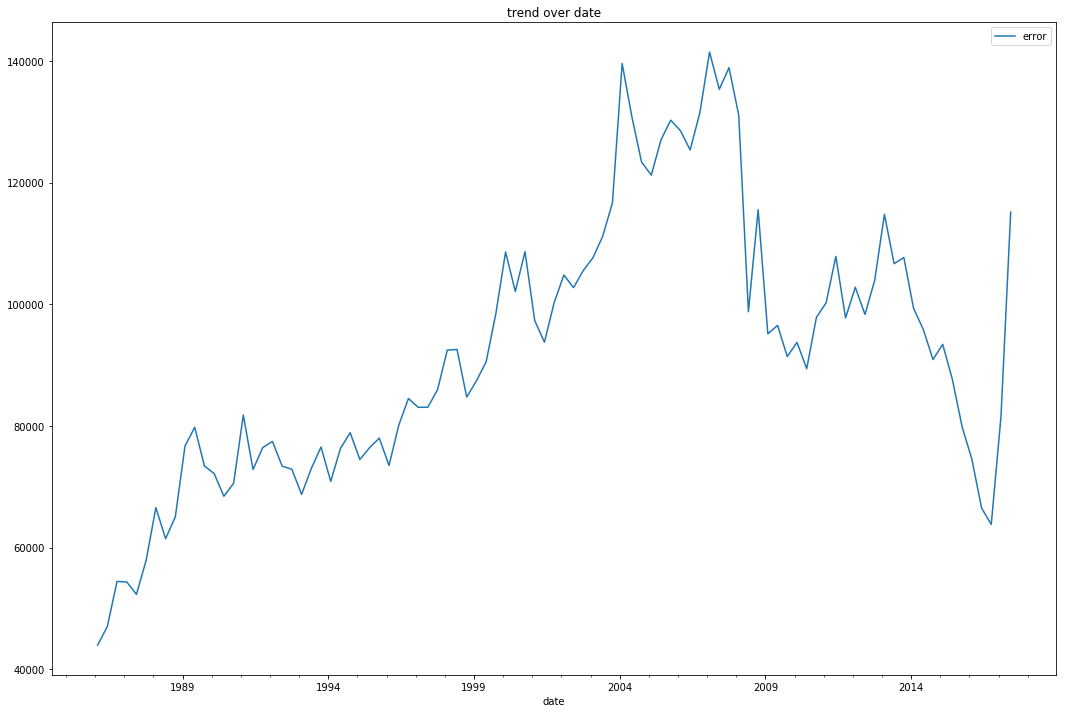

In [15]:
df_sum_4 = mr_full.summary()
plot_trends(df_sum_4, ['error'])

In [19]:
### validate sliding_window with walk-forward
mr_full.regress(df_all, param_grid=parameters, GridSearchCV={'verbose':True, 'n_jobs':-1})

[dp] prediction - data shape: (26051, 17), period: 1985-10-01 ~ 1986-05-30, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 13403, 13403, 12648
[dp] validation step is skipped
[dp] training size: 13403
[dp] prediction - data shape: (43749, 17), period: 1985-10-01 ~ 1986-09-30, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 26051, 26051, 17698
[dp] validation step is skipped
[dp] training size: 26051
[dp] prediction - data shape: (61867, 17), period: 1985-10-01 ~ 1987-01-30, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 43749, 43749, 18118
[dp] validation step is skipped
[dp] training size: 43749
[dp] prediction - data shape: (63207, 17), period: 1986-02-03 ~ 1987-05-29, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 47724, 47724, 15483
[dp] validation step is skipped
[dp] training size: 47724
[dp] prediction - data shape: (69151, 17), period: 1986-06-02 ~ 1987-09-30, sliding(in month): 12, test: 4
[dp] tr

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.9s finished
[dp] validation - sliding(in month):4, score: -2432692112.547437
[dp] validation - data shape: (110216, 17), sliding(in month): 8, period: 1985-10-01 ~ 1988-01-31
[dp] track/sliding/test window size: 95202, 26051, 15014
[dp] walk-forward train:(26051,), test:(15014,), scope:0 ~ 41064
[dp] walk-forward train:(26051,), test:(15014,), scope:15014 ~ 56078
[dp] walk-forward train:(26051,), test:(15014,), scope:30028 ~ 71092
[dp] walk-forward train:(26051,), test:(15014,), scope:45042 ~ 86106
[dp] training size: 95202


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    8.5s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    9.3s finished
[dp] validation - sliding(in month):8, score: -2499199348.598236
[dp] validation - data shape: (110216, 17), sliding(in month): 12, period: 1985-10-01 ~ 1988-01-31
[dp] track/sliding/test window size: 95202, 43749, 15014
[dp] walk-forward train:(43749,), test:(15014,), scope:0 ~ 58762
[dp] walk-forward train:(43749,), test:(15014,), scope:15014 ~ 73776
[dp] walk-forward train:(43749,), test:(15014,), scope:30028 ~ 88790
[dp] training size: 95202


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.2s finished
[dp] validation - sliding(in month):12, score: -2487935568.791562
[dp] prediction - data shape: (33221, 17), period: 1987-06-01 ~ 1988-01-31, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 18207, 18207, 15014
[dp] validation step is skipped
[dp] training size: 18207
[dp] prediction - data shape: (30695, 17), period: 1987-10-01 ~ 1988-05-31, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 15014, 15014, 15681
[dp] validation step is skipped
[dp] training size: 15014
[dp] prediction - data shape: (37290, 17), period: 1988-02-01 ~ 1988-09-30, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 15431, 15431, 21859
[dp] validation step is skipped
[dp] training size: 15431
[dp] prediction - data shape: (40106, 17), period: 1988-06-01 ~ 1989-01-31, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 21609, 21609, 18497
[dp] validation step is skipped
[dp] 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.4s finished
[dp] validation - sliding(in month):4, score: -4405127365.537791
[dp] validation - data shape: (121269, 17), sliding(in month): 8, period: 1987-10-01 ~ 1990-01-31
[dp] track/sliding/test window size: 106083, 30695, 15186
[dp] walk-forward train:(30695,), test:(15186,), scope:0 ~ 45880
[dp] walk-forward train:(30695,), test:(15186,), scope:15186 ~ 61066
[dp] walk-forward train:(30695,), test:(15186,), scope:30372 ~ 76252
[dp] walk-forward train:(30695,), test:(15186,), scope:45558 ~ 91438
[dp] training size: 106083


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    9.1s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    9.9s finished
[dp] validation - sliding(in month):8, score: -4426638494.739366
[dp] validation - data shape: (121269, 17), sliding(in month): 12, period: 1987-10-01 ~ 1990-01-31
[dp] track/sliding/test window size: 106083, 52304, 15186
[dp] walk-forward train:(52304,), test:(15186,), scope:0 ~ 67489
[dp] walk-forward train:(52304,), test:(15186,), scope:15186 ~ 82675
[dp] walk-forward train:(52304,), test:(15186,), scope:30372 ~ 97861
[dp] training size: 106083


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.6s finished
[dp] validation - sliding(in month):12, score: -5465440739.6275835
[dp] prediction - data shape: (33243, 17), period: 1989-06-01 ~ 1990-01-31, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 18057, 18057, 15186
[dp] validation step is skipped
[dp] training size: 18057
[dp] prediction - data shape: (28808, 17), period: 1989-10-02 ~ 1990-05-31, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 15186, 15186, 13622
[dp] validation step is skipped
[dp] training size: 15186
[dp] prediction - data shape: (26991, 17), period: 1990-02-01 ~ 1990-09-28, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 13034, 13034, 13957
[dp] validation step is skipped
[dp] training size: 13034
[dp] prediction - data shape: (22587, 17), period: 1990-06-01 ~ 1991-01-31, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 13369, 13369, 9218
[dp] validation step is skipped
[dp] 

Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    8.0s finished
[dp] validation - sliding(in month):4, score: -5251001880.892931
[dp] validation - data shape: (82430, 17), sliding(in month): 8, period: 1989-10-02 ~ 1992-01-31
[dp] track/sliding/test window size: 73281, 29122, 9149
[dp] walk-forward train:(29122,), test:(9149,), scope:0 ~ 38270
[dp] walk-forward train:(29122,), test:(9149,), scope:9149 ~ 47419
[dp] walk-forward train:(29122,), test:(9149,), scope:18298 ~ 56568
[dp] walk-forward train:(29122,), test:(9149,), scope:27447 ~ 65717
[dp] training size: 73281


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    8.4s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    9.3s finished
[dp] validation - sliding(in month):8, score: -5264338768.136841
[dp] validation - data shape: (82430, 17), sliding(in month): 12, period: 1989-10-02 ~ 1992-01-31
[dp] track/sliding/test window size: 73281, 42313, 9149
[dp] walk-forward train:(42313,), test:(9149,), scope:0 ~ 51461
[dp] walk-forward train:(42313,), test:(9149,), scope:9149 ~ 60610
[dp] walk-forward train:(42313,), test:(9149,), scope:18298 ~ 69759
[dp] training size: 73281


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.8s finished
[dp] validation - sliding(in month):12, score: -5407583685.051001
[dp] prediction - data shape: (20705, 17), period: 1991-06-03 ~ 1992-01-31, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 11556, 11556, 9149
[dp] validation step is skipped
[dp] training size: 11556
[dp] prediction - data shape: (19254, 17), period: 1991-10-01 ~ 1992-05-29, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 8830, 8830, 10424
[dp] validation step is skipped
[dp] training size: 8830
[dp] prediction - data shape: (20174, 17), period: 1992-02-03 ~ 1992-09-30, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 10105, 10105, 10069
[dp] validation step is skipped
[dp] training size: 10105
[dp] prediction - data shape: (19237, 17), period: 1992-06-01 ~ 1993-01-30, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 10069, 10069, 9168
[dp] validation step is skipped
[dp] train

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    3.4s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    5.3s finished
[dp] validation - sliding(in month):4, score: -5505806291.310549
[dp] validation - data shape: (68101, 17), sliding(in month): 8, period: 1991-10-01 ~ 1994-01-31
[dp] track/sliding/test window size: 58154, 19254, 9947
[dp] walk-forward train:(19254,), test:(9947,), scope:0 ~ 29200
[dp] walk-forward train:(19254,), test:(9947,), scope:9947 ~ 39147
[dp] walk-forward train:(19254,), test:(9947,), scope:19894 ~ 49094
[dp] training size: 58154


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.7s finished
[dp] validation - sliding(in month):8, score: -5340089678.263594
[dp] validation - data shape: (68101, 17), sliding(in month): 12, period: 1991-10-01 ~ 1994-01-31
[dp] track/sliding/test window size: 58154, 29323, 9947
[dp] walk-forward train:(29323,), test:(9947,), scope:0 ~ 39269
[dp] walk-forward train:(29323,), test:(9947,), scope:9947 ~ 49216
[dp] training size: 58154


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.4s finished
[dp] validation - sliding(in month):12, score: -4750515186.1239605
[dp] prediction - data shape: (38778, 17), period: 1992-10-01 ~ 1994-01-31, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 28831, 28831, 9947
[dp] validation step is skipped
[dp] training size: 28831
[dp] prediction - data shape: (40973, 17), period: 1993-02-01 ~ 1994-05-31, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 29610, 29610, 11363
[dp] validation step is skipped
[dp] training size: 29610
[dp] prediction - data shape: (43789, 17), period: 1993-06-01 ~ 1994-09-30, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 31825, 31825, 11964
[dp] validation step is skipped
[dp] training size: 31825
[dp] prediction - data shape: (41593, 17), period: 1993-10-01 ~ 1995-01-31, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 33045, 33045, 8548
[dp] validation step is skipped
[d

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.3s finished
[dp] validation - sliding(in month):4, score: -5620762575.599433
[dp] validation - data shape: (69057, 17), sliding(in month): 8, period: 1993-10-01 ~ 1996-01-31
[dp] track/sliding/test window size: 60059, 21310, 8998
[dp] walk-forward train:(21310,), test:(8998,), scope:0 ~ 30307
[dp] walk-forward train:(21310,), test:(8998,), scope:8998 ~ 39305
[dp] walk-forward train:(21310,), test:(8998,), scope:17996 ~ 48303
[dp] walk-forward train:(21310,), test:(8998,), scope:26994 ~ 57301
[dp] training size: 60059


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    7.1s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    8.0s finished
[dp] validation - sliding(in month):8, score: -5432387645.044645
[dp] validation - data shape: (69057, 17), sliding(in month): 12, period: 1993-10-01 ~ 1996-01-31
[dp] track/sliding/test window size: 60059, 33045, 8998
[dp] walk-forward train:(33045,), test:(8998,), scope:0 ~ 42042
[dp] walk-forward train:(33045,), test:(8998,), scope:8998 ~ 51040
[dp] walk-forward train:(33045,), test:(8998,), scope:17996 ~ 60038
[dp] training size: 60059


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.1s finished
[dp] validation - sliding(in month):12, score: -5205811286.390984
[dp] prediction - data shape: (36012, 17), period: 1994-10-03 ~ 1996-01-31, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 27014, 27014, 8998
[dp] validation step is skipped
[dp] training size: 27014
[dp] prediction - data shape: (37993, 17), period: 1995-02-01 ~ 1996-05-31, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 27464, 27464, 10529
[dp] validation step is skipped
[dp] training size: 27464
[dp] prediction - data shape: (40956, 17), period: 1995-06-01 ~ 1996-09-30, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 29349, 29349, 11607
[dp] validation step is skipped
[dp] training size: 29349
[dp] prediction - data shape: (40845, 17), period: 1995-10-02 ~ 1997-01-31, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 30699, 30699, 10146
[dp] validation step is skipped
[d

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    3.9s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    5.8s finished
[dp] validation - sliding(in month):4, score: -6569533966.73598
[dp] validation - data shape: (78951, 17), sliding(in month): 8, period: 1995-10-02 ~ 1998-01-30
[dp] track/sliding/test window size: 66224, 19527, 12727
[dp] walk-forward train:(19527,), test:(12727,), scope:0 ~ 32253
[dp] walk-forward train:(19527,), test:(12727,), scope:12727 ~ 44980
[dp] walk-forward train:(19527,), test:(12727,), scope:25454 ~ 57707
[dp] training size: 66224


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.0s finished
[dp] validation - sliding(in month):8, score: -6727132952.745265
[dp] validation - data shape: (78951, 17), sliding(in month): 12, period: 1995-10-02 ~ 1998-01-30
[dp] track/sliding/test window size: 66224, 30819, 12727
[dp] walk-forward train:(30819,), test:(12727,), scope:0 ~ 43545
[dp] walk-forward train:(30819,), test:(12727,), scope:12727 ~ 56272
[dp] training size: 66224


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.7s finished
[dp] validation - sliding(in month):12, score: -6847220205.515295
[dp] prediction - data shape: (26803, 17), period: 1997-06-02 ~ 1998-01-30, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 14076, 14076, 12727
[dp] validation step is skipped
[dp] training size: 14076
[dp] prediction - data shape: (27651, 17), period: 1997-10-01 ~ 1998-05-29, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 12349, 12349, 15302
[dp] validation step is skipped
[dp] training size: 12349
[dp] prediction - data shape: (32807, 17), period: 1998-02-02 ~ 1998-09-30, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 14924, 14924, 17883
[dp] validation step is skipped
[dp] training size: 14924
[dp] prediction - data shape: (31826, 17), period: 1998-06-01 ~ 1999-01-29, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 17442, 17442, 14384
[dp] validation step is skipped
[dp] 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.5s finished
[dp] validation - sliding(in month):4, score: -8133203981.896853
[dp] validation - data shape: (109695, 17), sliding(in month): 8, period: 1997-10-01 ~ 2000-01-31
[dp] track/sliding/test window size: 95172, 27651, 14523
[dp] walk-forward train:(27651,), test:(14523,), scope:0 ~ 42173
[dp] walk-forward train:(27651,), test:(14523,), scope:14523 ~ 56696
[dp] walk-forward train:(27651,), test:(14523,), scope:29046 ~ 71219
[dp] walk-forward train:(27651,), test:(14523,), scope:43569 ~ 85742
[dp] training size: 95172


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    8.4s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    9.2s finished
[dp] validation - sliding(in month):8, score: -7681540739.691169
[dp] validation - data shape: (109695, 17), sliding(in month): 12, period: 1997-10-01 ~ 2000-01-31
[dp] track/sliding/test window size: 95172, 45534, 14523
[dp] walk-forward train:(45534,), test:(14523,), scope:0 ~ 60056
[dp] walk-forward train:(45534,), test:(14523,), scope:14523 ~ 74579
[dp] walk-forward train:(45534,), test:(14523,), scope:29046 ~ 89102
[dp] training size: 95172


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.2s finished
[dp] validation - sliding(in month):12, score: -7558450906.186707
[dp] prediction - data shape: (64161, 17), period: 1998-10-01 ~ 2000-01-31, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 49638, 49638, 14523
[dp] validation step is skipped
[dp] training size: 49638
[dp] prediction - data shape: (66845, 17), period: 1999-02-01 ~ 2000-05-31, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 50218, 50218, 16627
[dp] validation step is skipped
[dp] training size: 50218
[dp] prediction - data shape: (67285, 17), period: 1999-06-01 ~ 2000-09-29, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 49208, 49208, 18077
[dp] validation step is skipped
[dp] training size: 49208
[dp] prediction - data shape: (63065, 17), period: 1999-10-01 ~ 2001-01-31, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 48455, 48455, 14610
[dp] validation step is skipped
[

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.7s finished
[dp] validation - sliding(in month):4, score: -10500196802.068167
[dp] validation - data shape: (109798, 17), sliding(in month): 8, period: 1999-10-01 ~ 2002-01-31
[dp] track/sliding/test window size: 95827, 31150, 13971
[dp] walk-forward train:(31150,), test:(13971,), scope:0 ~ 45120
[dp] walk-forward train:(31150,), test:(13971,), scope:13971 ~ 59091
[dp] walk-forward train:(31150,), test:(13971,), scope:27942 ~ 73062
[dp] walk-forward train:(31150,), test:(13971,), scope:41913 ~ 87033
[dp] training size: 95827


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    8.5s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    9.5s finished
[dp] validation - sliding(in month):8, score: -9787180070.676273
[dp] validation - data shape: (109798, 17), sliding(in month): 12, period: 1999-10-01 ~ 2002-01-31
[dp] track/sliding/test window size: 95827, 48455, 13971
[dp] walk-forward train:(48455,), test:(13971,), scope:0 ~ 62425
[dp] walk-forward train:(48455,), test:(13971,), scope:13971 ~ 76396
[dp] walk-forward train:(48455,), test:(13971,), scope:27942 ~ 90367
[dp] training size: 95827


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.5s finished
[dp] validation - sliding(in month):12, score: -9778797945.495476
[dp] prediction - data shape: (61343, 17), period: 2000-10-02 ~ 2002-01-31, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 47372, 47372, 13971
[dp] validation step is skipped
[dp] training size: 47372
[dp] prediction - data shape: (65004, 17), period: 2001-02-01 ~ 2002-05-31, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 46733, 46733, 18271
[dp] validation step is skipped
[dp] training size: 46733
[dp] prediction - data shape: (68527, 17), period: 2001-06-01 ~ 2002-09-30, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 49344, 49344, 19183
[dp] validation step is skipped
[dp] training size: 49344
[dp] prediction - data shape: (66551, 17), period: 2001-10-01 ~ 2003-01-31, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 50845, 50845, 15706
[dp] validation step is skipped
[

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.5s finished
[dp] validation - sliding(in month):4, score: -11519097812.62254
[dp] validation - data shape: (122534, 17), sliding(in month): 8, period: 2001-10-01 ~ 2004-01-30
[dp] track/sliding/test window size: 104581, 32242, 17953
[dp] walk-forward train:(32242,), test:(17953,), scope:0 ~ 50194
[dp] walk-forward train:(32242,), test:(17953,), scope:17953 ~ 68147
[dp] walk-forward train:(32242,), test:(17953,), scope:35906 ~ 86100
[dp] walk-forward train:(32242,), test:(17953,), scope:53859 ~ 104053
[dp] training size: 104581


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    9.6s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   10.1s finished
[dp] validation - sliding(in month):8, score: -10824381599.348461
[dp] validation - data shape: (122534, 17), sliding(in month): 12, period: 2001-10-01 ~ 2004-01-30
[dp] track/sliding/test window size: 104581, 50845, 17953
[dp] walk-forward train:(50845,), test:(17953,), scope:0 ~ 68797
[dp] walk-forward train:(50845,), test:(17953,), scope:17953 ~ 86750
[dp] training size: 104581


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.1s finished
[dp] validation - sliding(in month):12, score: -11376507580.318525
[dp] prediction - data shape: (55983, 17), period: 2003-02-03 ~ 2004-01-30, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 38030, 38030, 17953
[dp] validation step is skipped
[dp] training size: 38030
[dp] prediction - data shape: (58963, 17), period: 2003-06-02 ~ 2004-05-28, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 38456, 38456, 20507
[dp] validation step is skipped
[dp] training size: 38456
[dp] prediction - data shape: (59616, 17), period: 2003-10-01 ~ 2004-09-30, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 37858, 37858, 21758
[dp] validation step is skipped
[dp] training size: 37858
[dp] prediction - data shape: (58579, 17), period: 2004-02-02 ~ 2005-01-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 41663, 41663, 16916
[dp] validation step is skipped
[dp]

Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    8.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    8.3s finished
[dp] validation - sliding(in month):4, score: -16115252179.178034
[dp] validation - data shape: (129391, 17), sliding(in month): 8, period: 2003-10-01 ~ 2006-01-31
[dp] track/sliding/test window size: 114978, 37858, 14413
[dp] walk-forward train:(37858,), test:(14413,), scope:0 ~ 52270
[dp] walk-forward train:(37858,), test:(14413,), scope:14413 ~ 66683
[dp] walk-forward train:(37858,), test:(14413,), scope:28826 ~ 81096
[dp] walk-forward train:(37858,), test:(14413,), scope:43239 ~ 95509
[dp] walk-forward train:(37858,), test:(14413,), scope:57652 ~ 109922
[dp] training size: 114978


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.4s finished
[dp] validation - sliding(in month):8, score: -15608053166.152826
[dp] validation - data shape: (129391, 17), sliding(in month): 12, period: 2003-10-01 ~ 2006-01-31
[dp] track/sliding/test window size: 114978, 59616, 14413
[dp] walk-forward train:(59616,), test:(14413,), scope:0 ~ 74028
[dp] walk-forward train:(59616,), test:(14413,), scope:14413 ~ 88441
[dp] walk-forward train:(59616,), test:(14413,), scope:28826 ~ 102854
[dp] training size: 114978


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.5s finished
[dp] validation - sliding(in month):12, score: -15814731723.567589
[dp] prediction - data shape: (52859, 17), period: 2005-02-01 ~ 2006-01-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 38446, 38446, 14413
[dp] validation step is skipped
[dp] training size: 38446
[dp] prediction - data shape: (48253, 17), period: 2005-06-01 ~ 2006-05-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 34454, 34454, 13799
[dp] validation step is skipped
[dp] training size: 34454
[dp] prediction - data shape: (41373, 17), period: 2005-10-03 ~ 2006-09-29, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 27602, 27602, 13771
[dp] validation step is skipped
[dp] training size: 27602
[dp] prediction - data shape: (38338, 17), period: 2006-02-01 ~ 2007-01-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 26960, 26960, 11378
[dp] validation step is skipped
[dp]

Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    9.6s finished
[dp] validation - sliding(in month):4, score: -16367157379.22181
[dp] validation - data shape: (81094, 17), sliding(in month): 8, period: 2005-10-03 ~ 2008-01-31
[dp] track/sliding/test window size: 74031, 28581, 7063
[dp] walk-forward train:(28581,), test:(7063,), scope:0 ~ 35643
[dp] walk-forward train:(28581,), test:(7063,), scope:7063 ~ 42706
[dp] walk-forward train:(28581,), test:(7063,), scope:14126 ~ 49769
[dp] walk-forward train:(28581,), test:(7063,), scope:21189 ~ 56832
[dp] walk-forward train:(28581,), test:(7063,), scope:28252 ~ 63895
[dp] walk-forward train:(28581,), test:(7063,), scope:35315 ~ 70958
[dp] training size: 74031


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   12.3s finished
[dp] validation - sliding(in month):8, score: -15901246721.471523
[dp] validation - data shape: (81094, 17), sliding(in month): 12, period: 2005-10-03 ~ 2008-01-31
[dp] track/sliding/test window size: 74031, 41486, 7063
[dp] walk-forward train:(41486,), test:(7063,), scope:0 ~ 48548
[dp] walk-forward train:(41486,), test:(7063,), scope:7063 ~ 55611
[dp] walk-forward train:(41486,), test:(7063,), scope:14126 ~ 62674
[dp] walk-forward train:(41486,), test:(7063,), scope:21189 ~ 69737
[dp] training size: 74031


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   11.0s remaining:   11.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   12.2s finished
[dp] validation - sliding(in month):12, score: -15824383401.321547
[dp] prediction - data shape: (39721, 17), period: 2006-10-02 ~ 2008-01-31, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 32658, 32658, 7063
[dp] validation step is skipped
[dp] training size: 32658
[dp] prediction - data shape: (36932, 17), period: 2007-02-01 ~ 2008-05-30, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 28189, 28189, 8743
[dp] validation step is skipped
[dp] training size: 28189
[dp] prediction - data shape: (37276, 17), period: 2007-06-01 ~ 2008-09-30, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 25776, 25776, 11500
[dp] validation step is skipped
[dp] training size: 25776
[dp] prediction - data shape: (37915, 17), period: 2007-10-01 ~ 2009-01-30, sliding(in month): 12, test: 4
[dp] track

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    3.3s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    5.1s finished
[dp] validation - sliding(in month):4, score: -11145061944.640957
[dp] validation - data shape: (72669, 17), sliding(in month): 8, period: 2007-10-01 ~ 2010-01-29
[dp] track/sliding/test window size: 60925, 15652, 11744
[dp] walk-forward train:(15652,), test:(11744,), scope:0 ~ 27395
[dp] walk-forward train:(15652,), test:(11744,), scope:11744 ~ 39139
[dp] walk-forward train:(15652,), test:(11744,), scope:23488 ~ 50883
[dp] training size: 60925


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.1s finished
[dp] validation - sliding(in month):8, score: -10560928675.378391
[dp] validation - data shape: (72669, 17), sliding(in month): 12, period: 2007-10-01 ~ 2010-01-29
[dp] track/sliding/test window size: 60925, 27152, 11744
[dp] walk-forward train:(27152,), test:(11744,), scope:0 ~ 38895
[dp] walk-forward train:(27152,), test:(11744,), scope:11744 ~ 50639
[dp] training size: 60925


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.1s finished
[dp] validation - sliding(in month):12, score: -10615346053.885647
[dp] prediction - data shape: (34754, 17), period: 2009-02-02 ~ 2010-01-29, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 23010, 23010, 11744
[dp] validation step is skipped
[dp] training size: 23010
[dp] prediction - data shape: (35476, 17), period: 2009-06-01 ~ 2010-05-28, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 23792, 23792, 11684
[dp] validation step is skipped
[dp] training size: 23792
[dp] prediction - data shape: (34187, 17), period: 2009-10-01 ~ 2010-09-30, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 22765, 22765, 11422
[dp] validation step is skipped
[dp] training size: 22765
[dp] prediction - data shape: (32310, 17), period: 2010-02-01 ~ 2011-01-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 22819, 22819, 9491
[dp] validation step is skipped
[dp] 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.4s finished
[dp] validation - sliding(in month):4, score: -9141203402.051676
[dp] validation - data shape: (74847, 17), sliding(in month): 8, period: 2009-10-01 ~ 2012-01-31
[dp] track/sliding/test window size: 65110, 22765, 9737
[dp] walk-forward train:(22765,), test:(9737,), scope:0 ~ 32501
[dp] walk-forward train:(22765,), test:(9737,), scope:9737 ~ 42238
[dp] walk-forward train:(22765,), test:(9737,), scope:19474 ~ 51975
[dp] walk-forward train:(22765,), test:(9737,), scope:29211 ~ 61712
[dp] training size: 65110


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    7.1s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    7.9s finished
[dp] validation - sliding(in month):8, score: -8892488630.297173
[dp] validation - data shape: (74847, 17), sliding(in month): 12, period: 2009-10-01 ~ 2012-01-31
[dp] track/sliding/test window size: 65110, 34187, 9737
[dp] walk-forward train:(34187,), test:(9737,), scope:0 ~ 43923
[dp] walk-forward train:(34187,), test:(9737,), scope:9737 ~ 53660
[dp] walk-forward train:(34187,), test:(9737,), scope:19474 ~ 63397
[dp] training size: 65110


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.3s finished
[dp] validation - sliding(in month):12, score: -9469092571.403784
[dp] prediction - data shape: (31169, 17), period: 2011-02-01 ~ 2012-01-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 21432, 21432, 9737
[dp] validation step is skipped
[dp] training size: 21432
[dp] prediction - data shape: (32267, 17), period: 2011-06-01 ~ 2012-05-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 20882, 20882, 11385
[dp] validation step is skipped
[dp] training size: 20882
[dp] prediction - data shape: (33777, 17), period: 2011-10-03 ~ 2012-09-28, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 20508, 20508, 13269
[dp] validation step is skipped
[dp] training size: 20508
[dp] prediction - data shape: (35656, 17), period: 2012-02-01 ~ 2013-01-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 24040, 24040, 11616
[dp] validation step is skipped
[dp] t

Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    6.4s finished
[dp] validation - sliding(in month):4, score: -11160134930.701014
[dp] validation - data shape: (81369, 17), sliding(in month): 8, period: 2011-10-03 ~ 2014-01-31
[dp] track/sliding/test window size: 71284, 21315, 10085
[dp] walk-forward train:(21315,), test:(10085,), scope:0 ~ 31399
[dp] walk-forward train:(21315,), test:(10085,), scope:10085 ~ 41484
[dp] walk-forward train:(21315,), test:(10085,), scope:20170 ~ 51569
[dp] walk-forward train:(21315,), test:(10085,), scope:30255 ~ 61654
[dp] training size: 71284


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    6.8s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    7.9s finished
[dp] validation - sliding(in month):8, score: -10566510102.11086
[dp] validation - data shape: (81369, 17), sliding(in month): 12, period: 2011-10-03 ~ 2014-01-31
[dp] track/sliding/test window size: 71284, 33990, 10085
[dp] walk-forward train:(33990,), test:(10085,), scope:0 ~ 44074
[dp] walk-forward train:(33990,), test:(10085,), scope:10085 ~ 54159
[dp] walk-forward train:(33990,), test:(10085,), scope:20170 ~ 64244
[dp] training size: 71284


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.2s finished
[dp] validation - sliding(in month):12, score: -10956346529.197857
[dp] prediction - data shape: (35976, 17), period: 2013-02-01 ~ 2014-01-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 25891, 25891, 10085
[dp] validation step is skipped
[dp] training size: 25891
[dp] prediction - data shape: (33953, 17), period: 2013-06-03 ~ 2014-05-30, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 23262, 23262, 10691
[dp] validation step is skipped
[dp] training size: 23262
[dp] prediction - data shape: (31812, 17), period: 2013-10-01 ~ 2014-09-30, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 20579, 20579, 11233
[dp] validation step is skipped
[dp] training size: 20579
[dp] prediction - data shape: (28474, 17), period: 2014-02-03 ~ 2015-01-30, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 21727, 21727, 6747
[dp] validation step is skipped
[dp] 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.1s finished
[dp] validation - sliding(in month):4, score: -8807544938.820114
[dp] validation - data shape: (73256, 17), sliding(in month): 8, period: 2013-10-01 ~ 2016-01-29
[dp] track/sliding/test window size: 63282, 20579, 9974
[dp] walk-forward train:(20579,), test:(9974,), scope:0 ~ 30552
[dp] walk-forward train:(20579,), test:(9974,), scope:9974 ~ 40526
[dp] walk-forward train:(20579,), test:(9974,), scope:19948 ~ 50500
[dp] walk-forward train:(20579,), test:(9974,), scope:29922 ~ 60474
[dp] training size: 63282


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    6.3s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    7.2s finished
[dp] validation - sliding(in month):8, score: -8008362753.740054
[dp] validation - data shape: (73256, 17), sliding(in month): 12, period: 2013-10-01 ~ 2016-01-29
[dp] track/sliding/test window size: 63282, 31812, 9974
[dp] walk-forward train:(31812,), test:(9974,), scope:0 ~ 41785
[dp] walk-forward train:(31812,), test:(9974,), scope:9974 ~ 51759
[dp] walk-forward train:(31812,), test:(9974,), scope:19948 ~ 61733
[dp] training size: 63282


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.9s finished
[dp] validation - sliding(in month):12, score: -7723068585.66082
[dp] prediction - data shape: (41444, 17), period: 2014-10-01 ~ 2016-01-29, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 31470, 31470, 9974
[dp] validation step is skipped
[dp] training size: 31470
[dp] prediction - data shape: (46431, 17), period: 2015-02-02 ~ 2016-05-31, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 34697, 34697, 11734
[dp] validation step is skipped
[dp] training size: 34697
[dp] prediction - data shape: (48063, 17), period: 2015-06-01 ~ 2016-09-30, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 34582, 34582, 13481
[dp] validation step is skipped
[dp] training size: 34582
[dp] prediction - data shape: (45134, 17), period: 2015-10-01 ~ 2017-01-31, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 34715, 34715, 10419
[dp] validation step is skipped
[dp

[43976.5131943247,
 47258.108516511435,
 51938.43130005982,
 52697.61388399104,
 52469.42535143521,
 57546.51762204806,
 66574.30728919824,
 61475.26066468218,
 65062.16406356966,
 76730.80640345882,
 79776.94889857368,
 72143.3532896779,
 72173.2996729165,
 68451.73162090922,
 70569.77328333906,
 81794.13334772609,
 72839.97454525618,
 76310.32054399865,
 77457.21196046029,
 73399.23593784074,
 72880.99909425605,
 68743.93655741346,
 73014.91205074801,
 74284.23330501227,
 67845.87885902674,
 75533.88347148789,
 77519.7135729078,
 66025.6173919984,
 74367.10625383297,
 74691.61670982368,
 73542.13355548852,
 76345.40536627048,
 83708.63052235862,
 82330.75581368966,
 83374.72473666971,
 84976.10667023038,
 92475.48159931831,
 92573.17808162783,
 84751.52969722183,
 87414.71696669351,
 90557.41307196312,
 95728.509079206,
 109216.55934316186,
 103161.93046414742,
 109664.62544280181,
 96044.99254010318,
 92961.21241685604,
 96003.6733095036,
 100374.8257721562,
 101894.35908631417,
 10

[dp] data range: 1985-10-01 - 2017-09-27
[dp] sliding_windows: [4, 8, 12, 12, 12, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 4, 4, 4, 4, 4, 4, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 12, 12, 12, 12, 12, 12, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 12, 12, 12, 12, 12, 12]
[dp] errors: [43976.5131943247, 47258.108516511435, 51938.43130005982, 52697.61388399104, 52469.42535143521, 57546.51762204806, 66574.30728919824, 61475.26066468218, 65062.16406356966, 76730.80640345882, 79776.94889857368, 72143.3532896779, 72173.2996729165, 68451.73162090922, 70569.77328333906, 81794.13334772609, 72839.97454525618, 76310.32054399865, 77457.21196046029, 73399.23593784074, 72880.99909425605, 68743.93655741346, 73014.91205074801, 74284.23330501227, 67845.87885902674, 75533.88347148789, 77519.7135729078, 66025.6173919984, 74367.10625383297, 74691.61670982368, 73542.13355548852, 76345.4053662

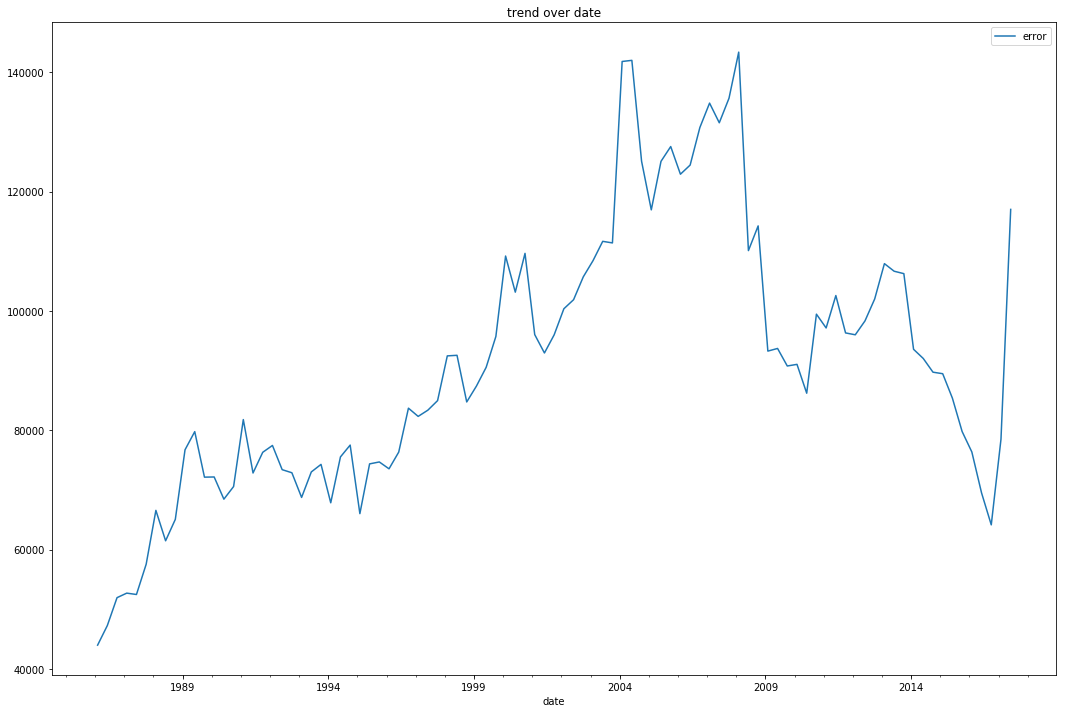

In [20]:
df_sum_auto = mr_full.summary()
plot_trends(df_sum_auto, ['error'])

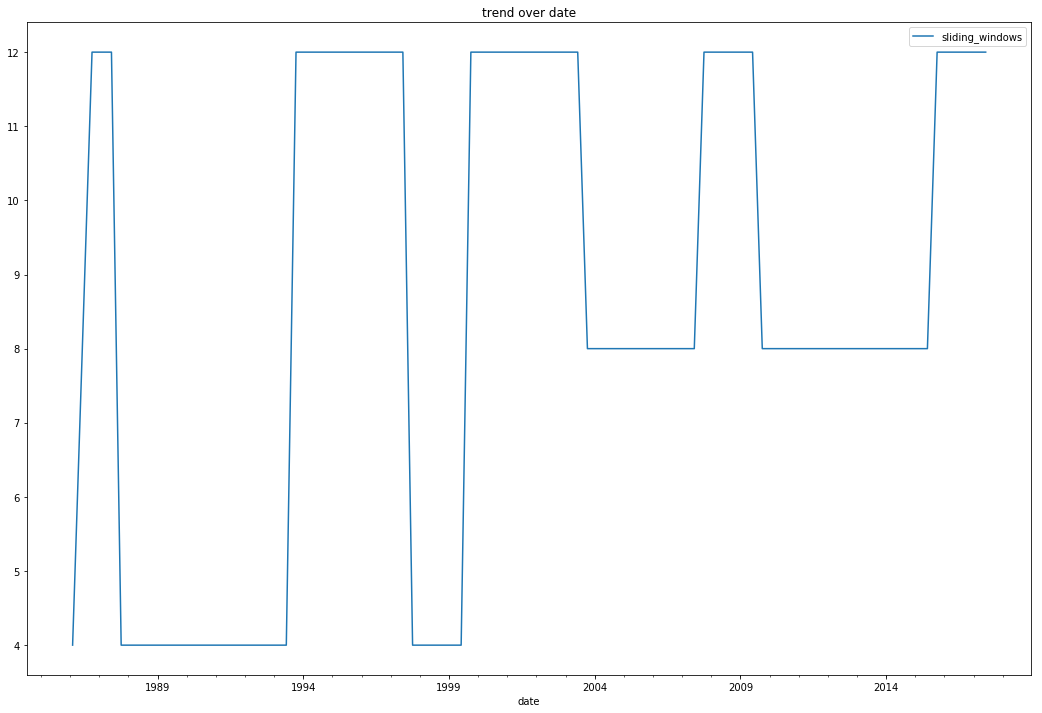

In [21]:
plot_trends(df_sum_auto, ['sliding_windows'])

In [42]:
### validate sliding_window with just last test_window
mr_full = ModelRegression(use_features_base, rf, track_window=12)
mr_full.regress(df_all, param_grid=parameters)

[dp] prediction - data shape: (26051, 17), period: 1985-10-01 ~ 1986-05-30, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 13403, 0, 12648
[dp] training size: 13403


8 4 4 0 95 4


[dp] prediction - data shape: (43749, 17), period: 1985-10-01 ~ 1986-09-30, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 26051, 13403, 17698
[dp] training size: 26051


12 4 8 1 95 8


[dp] validation - data shape: (61867, 17), sliding(in month): 4, period: 1985-10-01 ~ 1987-01-30
[dp] track/sliding/test window size: 43749, 12648, 18118
[dp] validation - sliding(in month):4, score: -46813.67130078244
[dp] validation - data shape: (61867, 17), sliding(in month): 8, period: 1985-10-01 ~ 1987-01-30
[dp] track/sliding/test window size: 43749, 26051, 18118
[dp] validation - sliding(in month):8, score: -46521.348791693395
[dp] validation - data shape: (61867, 17), sliding(in month): 12, period: 1985-10-01 ~ 1987-01-30
[dp] track/sliding/test window size: 43749, 26051, 18118
[dp] validation - sliding(in month):12, score: -46521.34879169339
[dp] prediction - data shape: (61867, 17), period: 1985-10-01 ~ 1987-01-30, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 43749, 26051, 18118
[dp] training size: 43749


16 4 12 2 95 12


[dp] prediction - data shape: (63207, 17), period: 1986-02-03 ~ 1987-05-29, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 47724, 29598, 15483
[dp] training size: 47724


20 4 12 3 95 16


[dp] prediction - data shape: (69151, 17), period: 1986-06-02 ~ 1987-09-30, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 50944, 35461, 18207
[dp] training size: 50944


24 4 12 4 95 20


[dp] validation - data shape: (66467, 17), sliding(in month): 4, period: 1986-10-01 ~ 1988-01-31
[dp] track/sliding/test window size: 51453, 15128, 15014
[dp] validation - sliding(in month):4, score: -52131.17885263345
[dp] validation - data shape: (66467, 17), sliding(in month): 8, period: 1986-10-01 ~ 1988-01-31
[dp] track/sliding/test window size: 51453, 33246, 15014
[dp] validation - sliding(in month):8, score: -51116.56928878356
[dp] validation - data shape: (66467, 17), sliding(in month): 12, period: 1986-10-01 ~ 1988-01-31
[dp] track/sliding/test window size: 51453, 33246, 15014
[dp] validation - sliding(in month):12, score: -51116.56928878356
[dp] prediction - data shape: (48349, 17), period: 1987-02-02 ~ 1988-01-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 33335, 15128, 15014
[dp] training size: 33335


28 4 8 5 95 24


[dp] prediction - data shape: (48902, 17), period: 1987-06-01 ~ 1988-05-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 33221, 18207, 15681
[dp] training size: 33221


32 4 8 6 95 28


[dp] prediction - data shape: (52304, 17), period: 1987-10-01 ~ 1988-09-30, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 30445, 14657, 21859
[dp] training size: 30445


36 4 8 7 95 32


[dp] validation - data shape: (70801, 17), sliding(in month): 4, period: 1987-10-01 ~ 1989-01-31
[dp] track/sliding/test window size: 52304, 15432, 18497
[dp] validation - sliding(in month):4, score: -60240.628134910025
[dp] validation - data shape: (70801, 17), sliding(in month): 8, period: 1987-10-01 ~ 1989-01-31
[dp] track/sliding/test window size: 52304, 30445, 18497
[dp] validation - sliding(in month):8, score: -60512.521530640646
[dp] validation - data shape: (70801, 17), sliding(in month): 12, period: 1987-10-01 ~ 1989-01-31
[dp] track/sliding/test window size: 52304, 30445, 18497
[dp] validation - sliding(in month):12, score: -60512.521530640646
[dp] prediction - data shape: (40106, 17), period: 1988-06-01 ~ 1989-01-31, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 21609, 0, 18497
[dp] training size: 21609


40 4 4 8 95 36


[dp] prediction - data shape: (35722, 17), period: 1988-10-03 ~ 1989-05-31, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 18497, 0, 17225
[dp] training size: 18497


44 4 4 9 95 40


[dp] prediction - data shape: (35282, 17), period: 1989-02-01 ~ 1989-09-29, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 16705, 0, 18577
[dp] training size: 16705


48 4 4 10 95 44


[dp] validation - data shape: (68965, 17), sliding(in month): 4, period: 1988-10-03 ~ 1990-01-31
[dp] track/sliding/test window size: 53779, 17147, 15186
[dp] validation - sliding(in month):4, score: -79468.111099494
[dp] validation - data shape: (68965, 17), sliding(in month): 8, period: 1988-10-03 ~ 1990-01-31
[dp] track/sliding/test window size: 53779, 35202, 15186
[dp] validation - sliding(in month):8, score: -81669.8430859198
[dp] validation - data shape: (68965, 17), sliding(in month): 12, period: 1988-10-03 ~ 1990-01-31
[dp] track/sliding/test window size: 53779, 35202, 15186
[dp] validation - sliding(in month):12, score: -81669.8430859198
[dp] prediction - data shape: (33243, 17), period: 1989-06-01 ~ 1990-01-31, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 18057, 0, 15186
[dp] training size: 18057


52 4 4 11 95 48


[dp] prediction - data shape: (28808, 17), period: 1989-10-02 ~ 1990-05-31, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 15186, 0, 13622
[dp] training size: 15186


56 4 4 12 95 52


[dp] prediction - data shape: (26991, 17), period: 1990-02-01 ~ 1990-09-28, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 13034, 0, 13957
[dp] training size: 13034


60 4 4 13 95 56


[dp] validation - data shape: (51395, 17), sliding(in month): 4, period: 1989-10-02 ~ 1991-01-31
[dp] track/sliding/test window size: 42177, 13549, 9218
[dp] validation - sliding(in month):4, score: -68330.47990920981
[dp] validation - data shape: (51395, 17), sliding(in month): 8, period: 1989-10-02 ~ 1991-01-31
[dp] track/sliding/test window size: 42177, 28220, 9218
[dp] validation - sliding(in month):8, score: -66153.02631549354
[dp] validation - data shape: (51395, 17), sliding(in month): 12, period: 1989-10-02 ~ 1991-01-31
[dp] track/sliding/test window size: 42177, 28220, 9218
[dp] validation - sliding(in month):12, score: -66153.02631549354
[dp] prediction - data shape: (36209, 17), period: 1990-02-01 ~ 1991-01-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 26991, 13034, 9218
[dp] training size: 26991


64 4 8 14 95 60


[dp] prediction - data shape: (32917, 17), period: 1990-06-01 ~ 1991-05-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 22587, 13369, 10330
[dp] training size: 22587


68 4 8 15 95 64


[dp] prediction - data shape: (31104, 17), period: 1990-10-01 ~ 1991-09-30, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 19109, 9018, 11995
[dp] training size: 19109


72 4 8 16 95 68


[dp] validation - data shape: (40253, 17), sliding(in month): 4, period: 1990-10-01 ~ 1992-01-31
[dp] track/sliding/test window size: 31104, 10091, 9149
[dp] validation - sliding(in month):4, score: -70772.11946497097
[dp] validation - data shape: (40253, 17), sliding(in month): 8, period: 1990-10-01 ~ 1992-01-31
[dp] track/sliding/test window size: 31104, 19109, 9149
[dp] validation - sliding(in month):8, score: -67489.26583591937
[dp] validation - data shape: (40253, 17), sliding(in month): 12, period: 1990-10-01 ~ 1992-01-31
[dp] track/sliding/test window size: 31104, 19109, 9149
[dp] validation - sliding(in month):12, score: -67489.26583591937
[dp] prediction - data shape: (31035, 17), period: 1991-02-01 ~ 1992-01-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 21886, 9891, 9149
[dp] training size: 21886


76 4 8 17 95 72


[dp] prediction - data shape: (30810, 17), period: 1991-06-03 ~ 1992-05-29, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 20386, 11361, 10424
[dp] training size: 20386


80 4 8 18 95 76


[dp] prediction - data shape: (29323, 17), period: 1991-10-01 ~ 1992-09-30, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 19254, 8830, 10069
[dp] training size: 19254


84 4 8 19 95 80


[dp] validation - data shape: (38491, 17), sliding(in month): 4, period: 1991-10-01 ~ 1993-01-30
[dp] track/sliding/test window size: 29323, 10301, 9168
[dp] validation - sliding(in month):4, score: -73471.9553100508
[dp] validation - data shape: (38491, 17), sliding(in month): 8, period: 1991-10-01 ~ 1993-01-30
[dp] track/sliding/test window size: 29323, 19254, 9168
[dp] validation - sliding(in month):8, score: -78234.38868993908
[dp] validation - data shape: (38491, 17), sliding(in month): 12, period: 1991-10-01 ~ 1993-01-30
[dp] track/sliding/test window size: 29323, 19254, 9168
[dp] validation - sliding(in month):12, score: -78234.38868993908
[dp] prediction - data shape: (19237, 17), period: 1992-06-01 ~ 1993-01-30, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 10069, 0, 9168
[dp] training size: 10069


88 4 4 20 95 84


[dp] prediction - data shape: (18087, 17), period: 1992-10-01 ~ 1993-05-28, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 8930, 0, 9157
[dp] training size: 8930


92 4 4 21 95 88


[dp] prediction - data shape: (19663, 17), period: 1993-02-01 ~ 1993-09-30, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 8919, 0, 10744
[dp] training size: 8919


96 4 4 22 95 92


[dp] validation - data shape: (38778, 17), sliding(in month): 4, period: 1992-10-01 ~ 1994-01-31
[dp] track/sliding/test window size: 28831, 8919, 9947
[dp] validation - sliding(in month):4, score: -72674.29418276933
[dp] validation - data shape: (38778, 17), sliding(in month): 8, period: 1992-10-01 ~ 1994-01-31
[dp] track/sliding/test window size: 28831, 18087, 9947
[dp] validation - sliding(in month):8, score: -70289.47517494037
[dp] validation - data shape: (38778, 17), sliding(in month): 12, period: 1992-10-01 ~ 1994-01-31
[dp] track/sliding/test window size: 28831, 18087, 9947
[dp] validation - sliding(in month):12, score: -70289.47517494038
[dp] prediction - data shape: (29610, 17), period: 1993-02-01 ~ 1994-01-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 19663, 8919, 9947
[dp] training size: 19663


100 4 8 23 95 96


[dp] prediction - data shape: (32054, 17), period: 1993-06-01 ~ 1994-05-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 20691, 10744, 11363
[dp] training size: 20691


104 4 8 24 95 100


[dp] prediction - data shape: (33045, 17), period: 1993-10-01 ~ 1994-09-30, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 21081, 9514, 11964
[dp] training size: 21081


108 4 8 25 95 104


[dp] validation - data shape: (41593, 17), sliding(in month): 4, period: 1993-10-01 ~ 1995-01-31
[dp] track/sliding/test window size: 33045, 11310, 8548
[dp] validation - sliding(in month):4, score: -76644.06122262034
[dp] validation - data shape: (41593, 17), sliding(in month): 8, period: 1993-10-01 ~ 1995-01-31
[dp] track/sliding/test window size: 33045, 21081, 8548
[dp] validation - sliding(in month):8, score: -74515.25404194517
[dp] validation - data shape: (41593, 17), sliding(in month): 12, period: 1993-10-01 ~ 1995-01-31
[dp] track/sliding/test window size: 33045, 21081, 8548
[dp] validation - sliding(in month):12, score: -74515.25404194517
[dp] prediction - data shape: (31646, 17), period: 1994-02-01 ~ 1995-01-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 23098, 11134, 8548
[dp] training size: 23098


112 4 8 26 95 108


[dp] prediction - data shape: (28492, 17), period: 1994-06-01 ~ 1995-05-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 20283, 11735, 8209
[dp] training size: 20283


116 4 8 27 95 112


[dp] prediction - data shape: (27014, 17), period: 1994-10-03 ~ 1995-09-29, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 16363, 8185, 10651
[dp] training size: 16363


120 4 8 28 95 116


[dp] validation - data shape: (36012, 17), sliding(in month): 4, period: 1994-10-03 ~ 1996-01-31
[dp] track/sliding/test window size: 27014, 8030, 8998
[dp] validation - sliding(in month):4, score: -75719.01892689588
[dp] validation - data shape: (36012, 17), sliding(in month): 8, period: 1994-10-03 ~ 1996-01-31
[dp] track/sliding/test window size: 27014, 16363, 8998
[dp] validation - sliding(in month):8, score: -72410.54453911306
[dp] validation - data shape: (36012, 17), sliding(in month): 12, period: 1994-10-03 ~ 1996-01-31
[dp] track/sliding/test window size: 27014, 16363, 8998
[dp] validation - sliding(in month):12, score: -72410.54453911306
[dp] prediction - data shape: (27464, 17), period: 1995-02-01 ~ 1996-01-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 18466, 7815, 8998
[dp] training size: 18466


124 4 8 29 95 120


[dp] prediction - data shape: (29784, 17), period: 1995-06-01 ~ 1996-05-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 19255, 10257, 10529
[dp] training size: 19255


128 4 8 30 95 124


[dp] prediction - data shape: (30699, 17), period: 1995-10-02 ~ 1996-09-30, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 19092, 8767, 11607
[dp] training size: 19092


132 4 8 31 95 128


[dp] validation - data shape: (40845, 17), sliding(in month): 4, period: 1995-10-02 ~ 1997-01-31
[dp] track/sliding/test window size: 30699, 10325, 10146
[dp] validation - sliding(in month):4, score: -79698.19029897302
[dp] validation - data shape: (40845, 17), sliding(in month): 8, period: 1995-10-02 ~ 1997-01-31
[dp] track/sliding/test window size: 30699, 19092, 10146
[dp] validation - sliding(in month):8, score: -77144.10949717267
[dp] validation - data shape: (40845, 17), sliding(in month): 12, period: 1995-10-02 ~ 1997-01-31
[dp] track/sliding/test window size: 30699, 19092, 10146
[dp] validation - sliding(in month):12, score: -77144.10949717266
[dp] prediction - data shape: (40845, 17), period: 1995-10-02 ~ 1997-01-31, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 30699, 19092, 10146
[dp] training size: 30699


136 4 12 32 95 132


[dp] prediction - data shape: (43150, 17), period: 1996-02-01 ~ 1997-05-30, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 31546, 21701, 11604
[dp] training size: 31546


140 4 12 33 95 136


[dp] prediction - data shape: (46697, 17), period: 1996-06-03 ~ 1997-09-30, sliding(in month): 12, test: 4
[dp] track/sliding/test window size: 32621, 21017, 14076
[dp] training size: 32621


144 4 12 34 95 140


[dp] validation - data shape: (48252, 17), sliding(in month): 4, period: 1996-10-01 ~ 1998-01-30
[dp] track/sliding/test window size: 35525, 11604, 12727
[dp] validation - sliding(in month):4, score: -83154.49905347779
[dp] validation - data shape: (48252, 17), sliding(in month): 8, period: 1996-10-01 ~ 1998-01-30
[dp] track/sliding/test window size: 35525, 21449, 12727
[dp] validation - sliding(in month):8, score: -81014.06557905897
[dp] validation - data shape: (48252, 17), sliding(in month): 12, period: 1996-10-01 ~ 1998-01-30
[dp] track/sliding/test window size: 35525, 21449, 12727
[dp] validation - sliding(in month):12, score: -81014.06557905897
[dp] prediction - data shape: (38106, 17), period: 1997-02-01 ~ 1998-01-30, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 25379, 11303, 12727
[dp] training size: 25379


148 4 8 35 95 144


[dp] prediction - data shape: (41727, 17), period: 1997-06-02 ~ 1998-05-29, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 26425, 13656, 15302
[dp] training size: 26425


152 4 8 36 95 148


[dp] prediction - data shape: (45534, 17), period: 1997-10-01 ~ 1998-09-30, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 27651, 12349, 17883
[dp] training size: 27651


156 4 8 37 95 152


[dp] validation - data shape: (59477, 17), sliding(in month): 4, period: 1997-10-01 ~ 1999-01-29
[dp] track/sliding/test window size: 45093, 15302, 14384
[dp] validation - sliding(in month):4, score: -90194.67262417157
[dp] validation - data shape: (59477, 17), sliding(in month): 8, period: 1997-10-01 ~ 1999-01-29
[dp] track/sliding/test window size: 45093, 27651, 14384
[dp] validation - sliding(in month):8, score: -91108.1625297762
[dp] validation - data shape: (59477, 17), sliding(in month): 12, period: 1997-10-01 ~ 1999-01-29
[dp] track/sliding/test window size: 45093, 27651, 14384
[dp] validation - sliding(in month):12, score: -91108.1625297762
[dp] prediction - data shape: (31826, 17), period: 1998-06-01 ~ 1999-01-29, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 17442, 0, 14384
[dp] training size: 17442


160 4 4 38 95 156


[dp] prediction - data shape: (30808, 17), period: 1998-10-01 ~ 1999-05-30, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 13943, 0, 16865
[dp] training size: 13943


164 4 4 39 95 160


[dp] prediction - data shape: (35695, 17), period: 1999-02-01 ~ 1999-09-30, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 16865, 0, 18830
[dp] training size: 16865


168 4 4 40 95 164


[dp] validation - data shape: (64161, 17), sliding(in month): 4, period: 1998-10-01 ~ 2000-01-31
[dp] track/sliding/test window size: 49638, 16865, 14523
[dp] validation - sliding(in month):4, score: -89939.95851612004
[dp] validation - data shape: (64161, 17), sliding(in month): 8, period: 1998-10-01 ~ 2000-01-31
[dp] track/sliding/test window size: 49638, 30808, 14523
[dp] validation - sliding(in month):8, score: -87167.49745308873
[dp] validation - data shape: (64161, 17), sliding(in month): 12, period: 1998-10-01 ~ 2000-01-31
[dp] track/sliding/test window size: 49638, 30808, 14523
[dp] validation - sliding(in month):12, score: -87167.49745308873
[dp] prediction - data shape: (50218, 17), period: 1999-02-01 ~ 2000-01-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 35695, 16865, 14523
[dp] training size: 35695


172 4 8 41 95 168


[dp] prediction - data shape: (49980, 17), period: 1999-06-01 ~ 2000-05-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 33353, 18830, 16627
[dp] training size: 33353


176 4 8 42 95 172


[dp] prediction - data shape: (48455, 17), period: 1999-10-01 ~ 2000-09-29, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 30378, 13765, 18077
[dp] training size: 30378


180 4 8 43 95 176


[dp] validation - data shape: (63065, 17), sliding(in month): 4, period: 1999-10-01 ~ 2001-01-31
[dp] track/sliding/test window size: 48455, 16115, 14610
[dp] validation - sliding(in month):4, score: -101235.02316509743
[dp] validation - data shape: (63065, 17), sliding(in month): 8, period: 1999-10-01 ~ 2001-01-31
[dp] track/sliding/test window size: 48455, 30378, 14610
[dp] validation - sliding(in month):8, score: -98950.10004140295
[dp] validation - data shape: (63065, 17), sliding(in month): 12, period: 1999-10-01 ~ 2001-01-31
[dp] track/sliding/test window size: 48455, 30378, 14610
[dp] validation - sliding(in month):12, score: -98950.10004140295
[dp] prediction - data shape: (48542, 17), period: 2000-02-01 ~ 2001-01-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 33932, 15855, 14610
[dp] training size: 33932


184 4 8 44 95 180


[dp] prediction - data shape: (46995, 17), period: 2000-06-01 ~ 2001-05-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 31915, 17305, 15080
[dp] training size: 31915


188 4 8 45 95 184


[dp] prediction - data shape: (47372, 17), period: 2000-10-02 ~ 2001-09-28, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 28864, 13746, 18508
[dp] training size: 28864


192 4 8 46 95 188


[dp] validation - data shape: (61343, 17), sliding(in month): 4, period: 2000-10-02 ~ 2002-01-31
[dp] track/sliding/test window size: 47372, 14904, 13971
[dp] validation - sliding(in month):4, score: -92533.45160535454
[dp] validation - data shape: (61343, 17), sliding(in month): 8, period: 2000-10-02 ~ 2002-01-31
[dp] track/sliding/test window size: 47372, 28864, 13971
[dp] validation - sliding(in month):8, score: -89948.45536026309
[dp] validation - data shape: (61343, 17), sliding(in month): 12, period: 2000-10-02 ~ 2002-01-31
[dp] track/sliding/test window size: 47372, 28864, 13971
[dp] validation - sliding(in month):12, score: -89948.45536026309
[dp] prediction - data shape: (46733, 17), period: 2001-02-01 ~ 2002-01-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 32762, 14254, 13971
[dp] training size: 32762


196 4 8 47 95 192


[dp] prediction - data shape: (49924, 17), period: 2001-06-01 ~ 2002-05-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 31653, 17682, 18271
[dp] training size: 31653


200 4 8 48 95 196


[dp] prediction - data shape: (50845, 17), period: 2001-10-01 ~ 2002-09-30, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 31662, 13636, 19183
[dp] training size: 31662


204 4 8 49 95 200


[dp] validation - data shape: (66551, 17), sliding(in month): 4, period: 2001-10-01 ~ 2003-01-31
[dp] track/sliding/test window size: 50845, 18026, 15706
[dp] validation - sliding(in month):4, score: -101660.57085550582
[dp] validation - data shape: (66551, 17), sliding(in month): 8, period: 2001-10-01 ~ 2003-01-31
[dp] track/sliding/test window size: 50845, 31662, 15706
[dp] validation - sliding(in month):8, score: -101697.45885481835
[dp] validation - data shape: (66551, 17), sliding(in month): 12, period: 2001-10-01 ~ 2003-01-31
[dp] track/sliding/test window size: 50845, 31662, 15706
[dp] validation - sliding(in month):12, score: -101697.45885481834
[dp] prediction - data shape: (34309, 17), period: 2002-06-03 ~ 2003-01-31, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 18603, 0, 15706
[dp] training size: 18603


208 4 4 50 95 204


[dp] prediction - data shape: (32631, 17), period: 2002-10-01 ~ 2003-05-30, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 15311, 0, 17320
[dp] training size: 15311


212 4 4 51 95 208


[dp] prediction - data shape: (38030, 17), period: 2003-02-03 ~ 2003-09-30, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 16925, 0, 21105
[dp] training size: 16925


216 4 4 52 95 212


[dp] validation - data shape: (71689, 17), sliding(in month): 4, period: 2002-10-01 ~ 2004-01-30
[dp] track/sliding/test window size: 53736, 17320, 17953
[dp] validation - sliding(in month):4, score: -108253.42623294855
[dp] validation - data shape: (71689, 17), sliding(in month): 8, period: 2002-10-01 ~ 2004-01-30
[dp] track/sliding/test window size: 53736, 32631, 17953
[dp] validation - sliding(in month):8, score: -107238.64241181624
[dp] validation - data shape: (71689, 17), sliding(in month): 12, period: 2002-10-01 ~ 2004-01-30
[dp] track/sliding/test window size: 53736, 32631, 17953
[dp] validation - sliding(in month):12, score: -107238.64241181624
[dp] prediction - data shape: (55983, 17), period: 2003-02-03 ~ 2004-01-30, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 38030, 16925, 17953
[dp] training size: 38030


220 4 8 53 95 216


[dp] prediction - data shape: (58963, 17), period: 2003-06-02 ~ 2004-05-28, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 38456, 20287, 20507
[dp] training size: 38456


224 4 8 54 95 220


[dp] prediction - data shape: (59616, 17), period: 2003-10-01 ~ 2004-09-30, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 37858, 17351, 21758
[dp] training size: 37858


228 4 8 55 95 224


[dp] validation - data shape: (76532, 17), sliding(in month): 4, period: 2003-10-01 ~ 2005-01-31
[dp] track/sliding/test window size: 59616, 19905, 16916
[dp] validation - sliding(in month):4, score: -129339.01625513526
[dp] validation - data shape: (76532, 17), sliding(in month): 8, period: 2003-10-01 ~ 2005-01-31
[dp] track/sliding/test window size: 59616, 37858, 16916
[dp] validation - sliding(in month):8, score: -140301.08807068676
[dp] validation - data shape: (76532, 17), sliding(in month): 12, period: 2003-10-01 ~ 2005-01-31
[dp] track/sliding/test window size: 59616, 37858, 16916
[dp] validation - sliding(in month):12, score: -140301.08807068676
[dp] prediction - data shape: (38674, 17), period: 2004-06-01 ~ 2005-01-31, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 21758, 0, 16916
[dp] training size: 21758


232 4 4 56 95 228


[dp] prediction - data shape: (35321, 17), period: 2004-10-01 ~ 2005-05-31, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 16916, 0, 18405
[dp] training size: 16916


236 4 4 57 95 232


[dp] prediction - data shape: (38446, 17), period: 2005-02-01 ~ 2005-09-30, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 18015, 0, 20431
[dp] training size: 18015


240 4 4 58 95 236


[dp] validation - data shape: (69775, 17), sliding(in month): 4, period: 2004-10-01 ~ 2006-01-31
[dp] track/sliding/test window size: 55362, 18247, 14413
[dp] validation - sliding(in month):4, score: -124296.1305078063
[dp] validation - data shape: (69775, 17), sliding(in month): 8, period: 2004-10-01 ~ 2006-01-31
[dp] track/sliding/test window size: 55362, 34931, 14413
[dp] validation - sliding(in month):8, score: -122570.68906075323
[dp] validation - data shape: (69775, 17), sliding(in month): 12, period: 2004-10-01 ~ 2006-01-31
[dp] track/sliding/test window size: 55362, 34931, 14413
[dp] validation - sliding(in month):12, score: -122570.68906075323
[dp] prediction - data shape: (52859, 17), period: 2005-02-01 ~ 2006-01-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 38446, 18015, 14413
[dp] training size: 38446


244 4 8 59 95 240


[dp] prediction - data shape: (48253, 17), period: 2005-06-01 ~ 2006-05-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 34454, 20041, 13799
[dp] training size: 34454


248 4 8 60 95 244


[dp] prediction - data shape: (41373, 17), period: 2005-10-03 ~ 2006-09-29, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 27602, 13836, 13771
[dp] training size: 27602


252 4 8 61 95 248


[dp] validation - data shape: (52751, 17), sliding(in month): 4, period: 2005-10-03 ~ 2007-01-31
[dp] track/sliding/test window size: 41373, 13580, 11378
[dp] validation - sliding(in month):4, score: -123270.54297958587
[dp] validation - data shape: (52751, 17), sliding(in month): 8, period: 2005-10-03 ~ 2007-01-31
[dp] track/sliding/test window size: 41373, 27602, 11378
[dp] validation - sliding(in month):8, score: -121321.21331012856
[dp] validation - data shape: (52751, 17), sliding(in month): 12, period: 2005-10-03 ~ 2007-01-31
[dp] track/sliding/test window size: 41373, 27602, 11378
[dp] validation - sliding(in month):12, score: -121321.21331012856
[dp] prediction - data shape: (38338, 17), period: 2006-02-01 ~ 2007-01-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 26960, 13189, 11378
[dp] training size: 26960


256 4 8 62 95 252


[dp] prediction - data shape: (35695, 17), period: 2006-06-01 ~ 2007-05-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 24539, 13161, 11156
[dp] training size: 24539


260 4 8 63 95 256


[dp] prediction - data shape: (32658, 17), period: 2006-10-02 ~ 2007-09-28, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 21964, 10753, 10694
[dp] training size: 21964


264 4 8 64 95 260


[dp] validation - data shape: (39721, 17), sliding(in month): 4, period: 2006-10-02 ~ 2008-01-31
[dp] track/sliding/test window size: 32658, 11041, 7063
[dp] validation - sliding(in month):4, score: -134857.48325728794
[dp] validation - data shape: (39721, 17), sliding(in month): 8, period: 2006-10-02 ~ 2008-01-31
[dp] track/sliding/test window size: 32658, 21964, 7063
[dp] validation - sliding(in month):8, score: -128694.2428120473
[dp] validation - data shape: (39721, 17), sliding(in month): 12, period: 2006-10-02 ~ 2008-01-31
[dp] track/sliding/test window size: 32658, 21964, 7063
[dp] validation - sliding(in month):12, score: -128694.2428120473
[dp] prediction - data shape: (28343, 17), period: 2007-02-01 ~ 2008-01-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 21280, 10586, 7063
[dp] training size: 21280


268 4 8 65 95 264


[dp] prediction - data shape: (25776, 17), period: 2007-06-01 ~ 2008-05-30, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 17033, 10124, 8743
[dp] training size: 17033


272 4 8 66 95 268


[dp] prediction - data shape: (27152, 17), period: 2007-10-01 ~ 2008-09-30, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 15652, 6909, 11500
[dp] training size: 15652


276 4 8 67 95 272


[dp] validation - data shape: (37915, 17), sliding(in month): 4, period: 2007-10-01 ~ 2009-01-30
[dp] track/sliding/test window size: 27152, 8743, 10763
[dp] validation - sliding(in month):4, score: -98733.42608663818
[dp] validation - data shape: (37915, 17), sliding(in month): 8, period: 2007-10-01 ~ 2009-01-30
[dp] track/sliding/test window size: 27152, 15652, 10763
[dp] validation - sliding(in month):8, score: -103011.47382709684
[dp] validation - data shape: (37915, 17), sliding(in month): 12, period: 2007-10-01 ~ 2009-01-30
[dp] track/sliding/test window size: 27152, 15652, 10763
[dp] validation - sliding(in month):12, score: -103011.47382709684
[dp] prediction - data shape: (22263, 17), period: 2008-06-02 ~ 2009-01-30, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 11500, 0, 10763
[dp] training size: 11500


280 4 4 68 95 276


[dp] prediction - data shape: (21438, 17), period: 2008-10-01 ~ 2009-05-29, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 10498, 0, 10940
[dp] training size: 10498


284 4 4 69 95 280


[dp] prediction - data shape: (23386, 17), period: 2009-02-02 ~ 2009-09-30, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 10675, 0, 12711
[dp] training size: 10675


288 4 4 70 95 284


[dp] validation - data shape: (45517, 17), sliding(in month): 4, period: 2008-10-01 ~ 2010-01-29
[dp] track/sliding/test window size: 33773, 10940, 11744
[dp] validation - sliding(in month):4, score: -95744.83193922683
[dp] validation - data shape: (45517, 17), sliding(in month): 8, period: 2008-10-01 ~ 2010-01-29
[dp] track/sliding/test window size: 33773, 21438, 11744
[dp] validation - sliding(in month):8, score: -97567.81065630281
[dp] validation - data shape: (45517, 17), sliding(in month): 12, period: 2008-10-01 ~ 2010-01-29
[dp] track/sliding/test window size: 33773, 21438, 11744
[dp] validation - sliding(in month):12, score: -97567.81065630281
[dp] prediction - data shape: (24079, 17), period: 2009-06-01 ~ 2010-01-29, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 12335, 0, 11744
[dp] training size: 12335


292 4 4 71 95 288


[dp] prediction - data shape: (22765, 17), period: 2009-10-01 ~ 2010-05-28, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 11081, 0, 11684
[dp] training size: 11081


296 4 4 72 95 292


[dp] prediction - data shape: (22819, 17), period: 2010-02-01 ~ 2010-09-30, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 11397, 0, 11422
[dp] training size: 11397


300 4 4 73 95 296


[dp] validation - data shape: (43678, 17), sliding(in month): 4, period: 2009-10-01 ~ 2011-01-31
[dp] track/sliding/test window size: 34187, 11397, 9491
[dp] validation - sliding(in month):4, score: -89510.12323674902
[dp] validation - data shape: (43678, 17), sliding(in month): 8, period: 2009-10-01 ~ 2011-01-31
[dp] track/sliding/test window size: 34187, 22765, 9491
[dp] validation - sliding(in month):8, score: -85709.53319850279
[dp] validation - data shape: (43678, 17), sliding(in month): 12, period: 2009-10-01 ~ 2011-01-31
[dp] track/sliding/test window size: 34187, 22765, 9491
[dp] validation - sliding(in month):12, score: -85709.53319850279
[dp] prediction - data shape: (32310, 17), period: 2010-02-01 ~ 2011-01-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 22819, 11397, 9491
[dp] training size: 22819


304 4 8 74 95 300


[dp] prediction - data shape: (31200, 17), period: 2010-06-01 ~ 2011-05-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 20913, 11422, 10287
[dp] training size: 20913


308 4 8 75 95 304


[dp] prediction - data shape: (30923, 17), period: 2010-10-01 ~ 2011-09-30, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 19599, 9068, 11324
[dp] training size: 19599


312 4 8 76 95 308


[dp] validation - data shape: (40660, 17), sliding(in month): 4, period: 2010-10-01 ~ 2012-01-31
[dp] track/sliding/test window size: 30923, 10303, 9737
[dp] validation - sliding(in month):4, score: -107266.38457900326
[dp] validation - data shape: (40660, 17), sliding(in month): 8, period: 2010-10-01 ~ 2012-01-31
[dp] track/sliding/test window size: 30923, 19599, 9737
[dp] validation - sliding(in month):8, score: -101798.35532552474
[dp] validation - data shape: (40660, 17), sliding(in month): 12, period: 2010-10-01 ~ 2012-01-31
[dp] track/sliding/test window size: 30923, 19599, 9737
[dp] validation - sliding(in month):12, score: -101798.35532552474
[dp] prediction - data shape: (31169, 17), period: 2011-02-01 ~ 2012-01-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 21432, 10108, 9737
[dp] training size: 21432


316 4 8 77 95 312


[dp] prediction - data shape: (32267, 17), period: 2011-06-01 ~ 2012-05-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 20882, 11145, 11385
[dp] training size: 20882


320 4 8 78 95 316


[dp] prediction - data shape: (33777, 17), period: 2011-10-03 ~ 2012-09-28, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 20508, 9171, 13269
[dp] training size: 20508


324 4 8 79 95 320


[dp] validation - data shape: (45393, 17), sliding(in month): 4, period: 2011-10-03 ~ 2013-01-31
[dp] track/sliding/test window size: 33777, 11053, 11616
[dp] validation - sliding(in month):4, score: -100330.8490027368
[dp] validation - data shape: (45393, 17), sliding(in month): 8, period: 2011-10-03 ~ 2013-01-31
[dp] track/sliding/test window size: 33777, 20508, 11616
[dp] validation - sliding(in month):8, score: -96899.82048935282
[dp] validation - data shape: (45393, 17), sliding(in month): 12, period: 2011-10-03 ~ 2013-01-31
[dp] track/sliding/test window size: 33777, 20508, 11616
[dp] validation - sliding(in month):12, score: -96899.82048935282
[dp] prediction - data shape: (35656, 17), period: 2012-02-01 ~ 2013-01-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 24040, 10771, 11616
[dp] training size: 24040


328 4 8 80 95 324


[dp] prediction - data shape: (36788, 17), period: 2012-06-01 ~ 2013-05-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 24271, 12655, 12517
[dp] training size: 24271


332 4 8 81 95 328


[dp] prediction - data shape: (37507, 17), period: 2012-10-01 ~ 2013-09-30, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 23829, 11414, 13678
[dp] training size: 23829


336 4 8 82 95 332


[dp] validation - data shape: (47592, 17), sliding(in month): 4, period: 2012-10-01 ~ 2014-01-31
[dp] track/sliding/test window size: 37507, 12415, 10085
[dp] validation - sliding(in month):4, score: -105269.57738754641
[dp] validation - data shape: (47592, 17), sliding(in month): 8, period: 2012-10-01 ~ 2014-01-31
[dp] track/sliding/test window size: 37507, 23829, 10085
[dp] validation - sliding(in month):8, score: -107040.8904745054
[dp] validation - data shape: (47592, 17), sliding(in month): 12, period: 2012-10-01 ~ 2014-01-31
[dp] track/sliding/test window size: 37507, 23829, 10085
[dp] validation - sliding(in month):12, score: -107040.8904745054
[dp] prediction - data shape: (23459, 17), period: 2013-06-03 ~ 2014-01-31, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 13374, 0, 10085
[dp] training size: 13374


340 4 4 83 95 336


[dp] prediction - data shape: (20579, 17), period: 2013-10-01 ~ 2014-05-30, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 9888, 0, 10691
[dp] training size: 9888


344 4 4 84 95 340


[dp] prediction - data shape: (21727, 17), period: 2014-02-03 ~ 2014-09-30, sliding(in month): 4, test: 4
[dp] track/sliding/test window size: 10494, 0, 11233
[dp] training size: 10494


348 4 4 85 95 344


[dp] validation - data shape: (38559, 17), sliding(in month): 4, period: 2013-10-01 ~ 2015-01-30
[dp] track/sliding/test window size: 31812, 10691, 6747
[dp] validation - sliding(in month):4, score: -95828.63048832984
[dp] validation - data shape: (38559, 17), sliding(in month): 8, period: 2013-10-01 ~ 2015-01-30
[dp] track/sliding/test window size: 31812, 20579, 6747
[dp] validation - sliding(in month):8, score: -91711.73506828681
[dp] validation - data shape: (38559, 17), sliding(in month): 12, period: 2013-10-01 ~ 2015-01-30
[dp] track/sliding/test window size: 31812, 20579, 6747
[dp] validation - sliding(in month):12, score: -91711.73506828683
[dp] prediction - data shape: (28474, 17), period: 2014-02-03 ~ 2015-01-30, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 21727, 10494, 6747
[dp] training size: 21727


352 4 8 86 95 348


[dp] prediction - data shape: (29576, 17), period: 2014-06-02 ~ 2015-05-29, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 17809, 11031, 11767
[dp] training size: 17809


356 4 8 87 95 352


[dp] prediction - data shape: (31691, 17), period: 2014-10-01 ~ 2015-09-30, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 18343, 6576, 13348
[dp] training size: 18343


360 4 8 88 95 356


[dp] validation - data shape: (41444, 17), sliding(in month): 4, period: 2014-10-01 ~ 2016-01-29
[dp] track/sliding/test window size: 31470, 11767, 9974
[dp] validation - sliding(in month):4, score: -87420.19708521427
[dp] validation - data shape: (41444, 17), sliding(in month): 8, period: 2014-10-01 ~ 2016-01-29
[dp] track/sliding/test window size: 31470, 18343, 9974
[dp] validation - sliding(in month):8, score: -84577.48728927245
[dp] validation - data shape: (41444, 17), sliding(in month): 12, period: 2014-10-01 ~ 2016-01-29
[dp] track/sliding/test window size: 31470, 18343, 9974
[dp] validation - sliding(in month):12, score: -84577.48728927245
[dp] prediction - data shape: (34697, 17), period: 2015-02-02 ~ 2016-01-29, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 24723, 11596, 9974
[dp] training size: 24723


364 4 8 89 95 360


[dp] prediction - data shape: (34835, 17), period: 2015-06-01 ~ 2016-05-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 23101, 13127, 11734
[dp] training size: 23101


368 4 8 90 95 364


[dp] prediction - data shape: (34715, 17), period: 2015-10-01 ~ 2016-09-30, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 21234, 9442, 13481
[dp] training size: 21234


372 4 8 91 95 368


[dp] validation - data shape: (45134, 17), sliding(in month): 4, period: 2015-10-01 ~ 2017-01-31
[dp] track/sliding/test window size: 34715, 11481, 10419
[dp] validation - sliding(in month):4, score: -66391.15104964911
[dp] validation - data shape: (45134, 17), sliding(in month): 8, period: 2015-10-01 ~ 2017-01-31
[dp] track/sliding/test window size: 34715, 21234, 10419
[dp] validation - sliding(in month):8, score: -65621.362205862
[dp] validation - data shape: (45134, 17), sliding(in month): 12, period: 2015-10-01 ~ 2017-01-31
[dp] track/sliding/test window size: 34715, 21234, 10419
[dp] validation - sliding(in month):12, score: -65621.362205862
[dp] prediction - data shape: (35381, 17), period: 2016-02-01 ~ 2017-01-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 24962, 11481, 10419
[dp] training size: 24962


376 4 8 92 95 372


[dp] prediction - data shape: (35132, 17), period: 2016-06-01 ~ 2017-05-31, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 23647, 13228, 11485
[dp] training size: 23647


380 4 8 93 95 376


[dp] prediction - data shape: (34191, 17), period: 2016-10-03 ~ 2017-09-27, sliding(in month): 8, test: 4
[dp] track/sliding/test window size: 21415, 9979, 12776
[dp] training size: 21415


384 4 8 94 95 380


[43622.74965494429,
 46521.34879169339,
 51608.6355973454,
 51594.719532203206,
 51864.57246519474,
 55888.52975882361,
 65040.834480538266,
 60512.521530640646,
 63989.74125752722,
 75537.0989970009,
 78230.60426215506,
 72022.02200107652,
 71407.39142625756,
 67729.47278673723,
 68520.13078994758,
 84585.5104797485,
 67489.26583591937,
 72551.7914932537,
 70698.43684250089,
 78234.38868993908,
 72660.69901818913,
 67985.23041326975,
 72674.29418276933,
 72338.03551826064,
 66515.18465515425,
 74515.25404194517,
 78291.71858345983,
 67729.32901121241,
 72410.54453911306,
 76481.10501599834,
 73911.95426729505,
 77144.10949717267,
 83666.66353743983,
 82275.36377811144,
 83063.34928089273,
 82861.31926731305,
 89457.53288674793,
 90933.6466826748,
 84760.80840121998,
 86643.06244893435,
 89939.95851612004,
 96410.42640194185,
 107154.8911865898,
 98950.10004140295,
 106555.14264641947,
 92822.70485317137,
 89948.45536026309,
 97881.43156243146,
 99739.47125783877,
 101697.45885481835,


[dp] data range: 1985-10-01 - 2017-09-27
[dp] sliding_windows: [4, 8, 12, 12, 12, 8, 8, 8, 4, 4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 8, 4, 4, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 12, 12, 12, 8, 8, 8, 4, 4, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 4, 4, 8, 8, 8, 4, 4, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 4, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8]
[dp] errors: [43622.74965494429, 46521.34879169339, 51608.6355973454, 51594.719532203206, 51864.57246519474, 55888.52975882361, 65040.834480538266, 60512.521530640646, 63989.74125752722, 75537.0989970009, 78230.60426215506, 72022.02200107652, 71407.39142625756, 67729.47278673723, 68520.13078994758, 84585.5104797485, 67489.26583591937, 72551.7914932537, 70698.43684250089, 78234.38868993908, 72660.69901818913, 67985.23041326975, 72674.29418276933, 72338.03551826064, 66515.18465515425, 74515.25404194517, 78291.71858345983, 67729.32901121241, 72410.54453911306, 76481.10501599834, 73911.95426729505, 77144.10949717267, 83666.66353743983, 82275

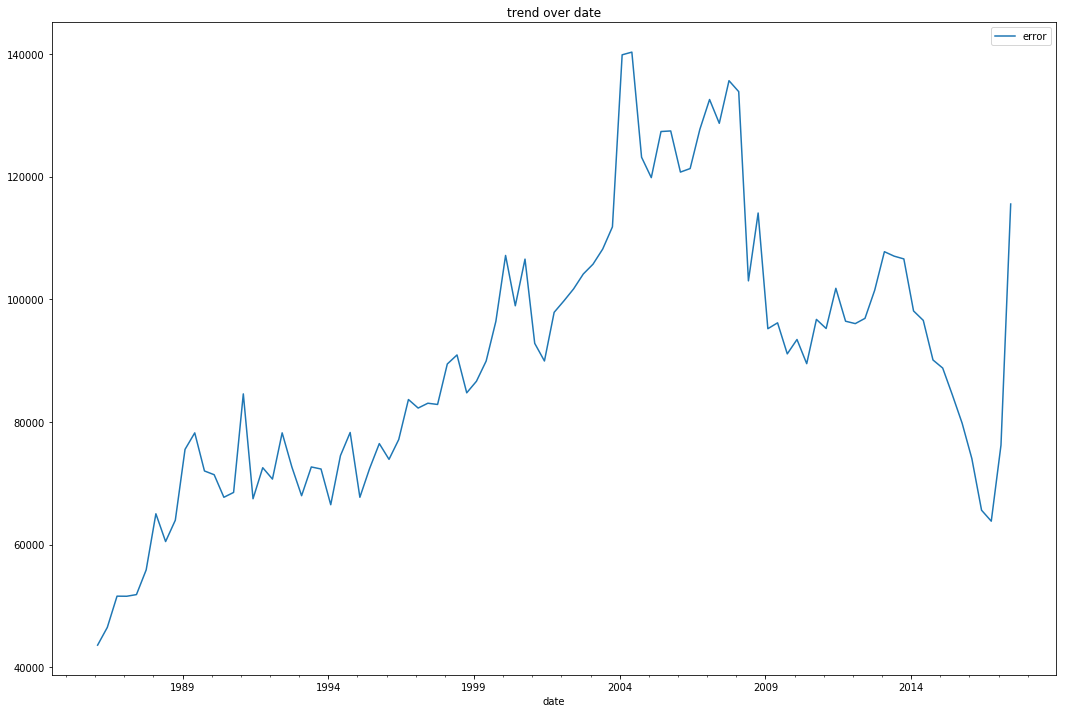

In [43]:
df_sum_auto = mr_full.summary()
plot_trends(df_sum_auto, ['error'])

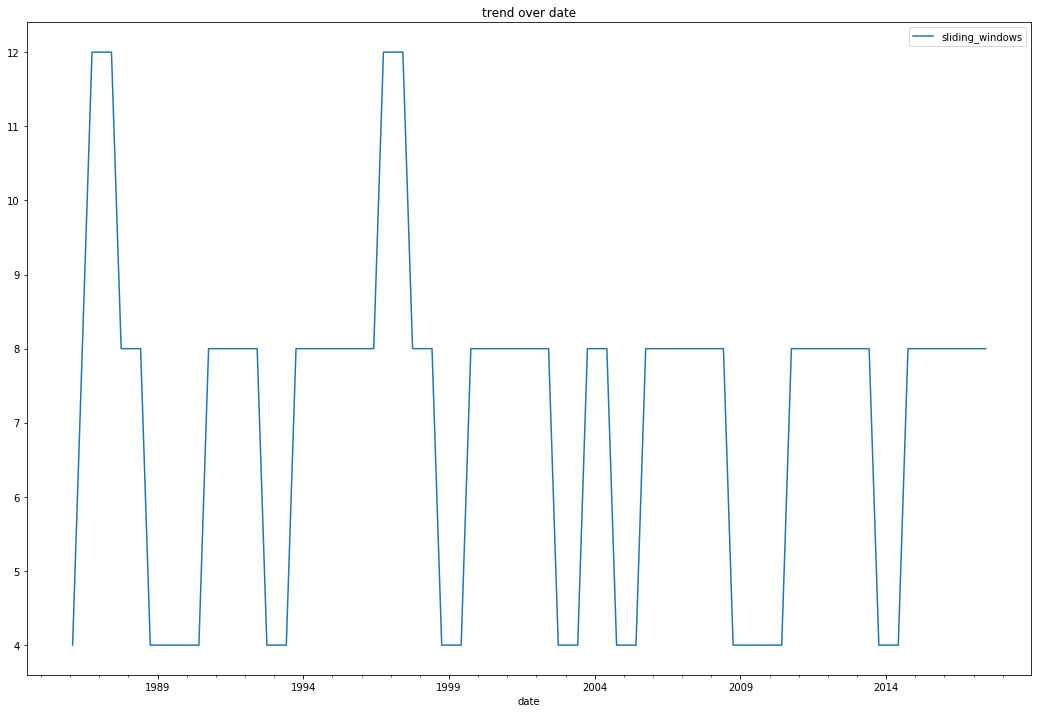

In [44]:
plot_trends(df_sum_auto, ['sliding_windows'])